### kaggle Advanced Regression Techniques

In [26]:
!python -m jupytext --sync WMQhouseprice.ipynb

[jupytext] Reading WMQhouseprice.ipynb in format ipynb
[jupytext] Unchanged WMQhouseprice.ipynb
[jupytext] Updating WMQhouseprice.py


In [ ]:
import numpy as np
import pandas as pd
import ultraplot as uplt
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from lightgbm import LGBMRegressor, early_stopping
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from scipy import stats
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import yeojohnson

import warnings
import optuna
from optuna.samplers import TPESampler
from scipy.optimize import minimize
from sklearn.model_selection import learning_curve
#import data_describe as ddb

Feature Engineering comprises four core mechanisms: Hierarchical & Informative Imputation Spatially correlated missingness (e.g., LotFrontage) is reconstructed via neighborhood-level medians, while structural sparsity (e.g., PoolQC, GarageType) is handled by introducing explicit "Absence Indicators" (binary flags) to capture the informative value of missing data. Distributional Rectification via Power TransformsTo satisfy the homoscedasticity assumptions of linear estimators, the pipeline dynamically assesses feature skewness. Variables exceeding a skewness threshold of |0.75|undergo non-linear transformations, automatically selecting between Box-Cox and Yeo-Johnson to maximize normality.Leakage-Resistant Target EncodingFor high-cardinality categorical features, the system implements K-Fold Regularized Target Encoding. By computing category means within isolated cross-validation folds, the architecture explicitly prevents target leakage. the pipeline engineers "holistic" meta-attributes to capture interaction effects. This includes aggregating surface areas, synthesizing quality-condition indices, and converting sparse continuous variables into binary density flags, thereby enhancing the decision boundaries for tree-based ensembles.

In [ ]:
def preprocess(alldata, ytrain=None, idxT=None, Trainphase=True):
    alldata=alldata.copy()

    if 'MSSubClass' in alldata.columns:
        alldata['MSSubClass']=alldata['MSSubClass'].astype(str)
    if 'Utilities' in alldata.columns:
        alldata=alldata.drop('Utilities', axis=1)
    high_mis=['PoolQC', 'MiscFeature', 'Alley']
    for c in high_mis:
        if c in alldata.columns:
            alldata[c]=alldata[c].fillna('None')
            top2=alldata[c].value_counts().nlargest(2).index.tolist()
            if 'None' not in top2:
                top2.append('None')
            alldata[c]=alldata[c].apply(lambda x: x if x in top2 else 'Other')
    
    mid_mis=['FireplaceQu', 'Fence']
    for c in mid_mis:
        if c in alldata.columns:
            alldata[f'{c}_NA']=alldata[c].isna().astype(int)
            alldata[c]=alldata[c].fillna('None')
    
    gar_cols=['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
    if all(c in alldata.columns for c in gar_cols):
        alldata['Gar_NA']=alldata['GarageType'].isna().astype(int)
    for c in gar_cols:
        if c in alldata.columns:
            alldata[c]=alldata[c].fillna('None')
    
    if 'GarageYrBlt' in alldata.columns:
        alldata['GarYr_imp']=alldata['GarageYrBlt'].isna().astype(int)
        alldata['GarageYrBlt']=alldata['GarageYrBlt'].fillna(alldata['YearBuilt'])
    
    bsmt_cols=['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
    if all(c in alldata.columns for c in bsmt_cols):
        alldata['Bsmt_NA']=alldata['BsmtQual'].isna().astype(int)
    for c in bsmt_cols:
        if c in alldata.columns:
            alldata[c]=alldata[c].fillna('None')
    
    if 'MasVnrType' in alldata.columns:
        alldata['MasVnrType']=alldata['MasVnrType'].fillna('None')
    if 'MasVnrArea' in alldata.columns:
        alldata['MasVnrArea']=alldata['MasVnrArea'].fillna(0)

    true_mis=['Electrical', 'Functional', 'KitchenQual', 'SaleType', 'MSZoning', 'Exterior1st', 'Exterior2nd']
    for c in true_mis:
        if c in alldata.columns and alldata[c].isna().any():
            alldata[c]=alldata[c].fillna(alldata[c].mode()[0])

    if 'LotFrontage' in alldata.columns:
        alldata['LotFr_NA']=alldata['LotFrontage'].isna().astype(int)
        alldata['LotFrontage']=alldata.groupby('Neighborhood')['LotFrontage'].transform(
            lambda x: x.fillna(x.median()))
        alldata['LotFrontage']=alldata['LotFrontage'].fillna(alldata['LotFrontage'].median())

    ncols=alldata.select_dtypes(include=[np.number]).columns
    for c in ncols:
        if alldata[c].isna().any():
            alldata[c]=alldata[c].fillna(0)
    
    ccols=alldata.select_dtypes(include=['object']).columns
    for c in ccols:
        if alldata[c].isna().any():
            alldata[c]=alldata[c].fillna(alldata[c].mode()[0])
    
    qualmap={'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
    qualc=['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
                 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
    for c in qualc:
        if c in alldata.columns:
            alldata[c]=alldata[c].map(qualmap).fillna(0).astype(int)

    expomap={'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
    if 'BsmtExposure' in alldata.columns:
        alldata['BsmtExposure']=alldata['BsmtExposure'].map(expomap).fillna(0).astype(int)

    fin_map={'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}
    for c in ['BsmtFinType1', 'BsmtFinType2']:
        if c in alldata.columns:
            alldata[c]=alldata[c].map(fin_map).fillna(0).astype(int)

    gfin_map={'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
    if 'GarageFinish' in alldata.columns:
        alldata['GarageFinish']=alldata['GarageFinish'].map(gfin_map).fillna(0).astype(int)
    

    fence_map={'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'None': 0}
    if 'Fence' in alldata.columns:
        alldata['Fence']=alldata['Fence'].map(fence_map).fillna(0).astype(int)

    func_map={'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0}
    if 'Functional' in alldata.columns:
        alldata['Functional']=alldata['Functional'].map(func_map).fillna(7).astype(int)

    alldata['TotalSF']=alldata['TotalBsmtSF'].fillna(0) + alldata['1stFlrSF'].fillna(0) + alldata['2ndFlrSF'].fillna(0)
    alldata['TotalArea']=alldata['TotalSF'] + alldata.get('GarageArea', 0) + alldata.get('WoodDeckSF', 0) + alldata.get('OpenPorchSF', 0)
    alldata['OvlScore']=alldata['OverallQual'] * alldata['OverallCond']
    alldata['ExtScore']=alldata['OverallQual'] * alldata['TotalSF']
    alldata['HouseAge']=alldata['YrSold'] - alldata['YearBuilt']
    alldata['Age']=alldata['HouseAge']  
    alldata['RemodAge']=alldata['YrSold'] - alldata['YearRemodAdd']
    alldata['IsRemodeled']=(alldata['YearBuilt'] != alldata['YearRemodAdd']).astype(int)
    alldata['IsRemod']=alldata['IsRemodeled']  
    alldata['IsNew']=(alldata['SaleCondition'] == 'Partial').astype(int) if 'SaleCondition' in alldata.columns else (alldata['HouseAge'] <= 1).astype(int)
    alldata['TotBath']=(alldata['FullBath'] + 0.5 * alldata['HalfBath'] +
                          alldata['BsmtFullBath'] + 0.5 * alldata['BsmtHalfBath'])
    alldata['TotRms']=alldata['TotRmsAbvGrd'] + alldata['FullBath'] + alldata['HalfBath']
    alldata['TotPorch']=(alldata['OpenPorchSF'] + alldata['EnclosedPorch'] +
                           alldata['3SsnPorch'] + alldata['ScreenPorch'] + alldata['WoodDeckSF'])
    alldata['HasPool']=(alldata['PoolArea'] > 0).astype(int)
    alldata['Has2ndFl']=(alldata['2ndFlrSF'] > 0).astype(int)
    alldata['HasGar']=(alldata['GarageArea'] > 0).astype(int)
    alldata['HasBsmt']=(alldata['TotalBsmtSF'] > 0).astype(int)
    alldata['HasFP']=(alldata['Fireplaces'] > 0).astype(int)
    alldata['HasPool']=(alldata['PoolArea'] > 0).astype(int)
    alldata['Has2ndFl']=(alldata['2ndFlrSF'] > 0).astype(int)
    alldata['HasGar']=(alldata['GarageArea'] > 0).astype(int)
    alldata['HasBsmt']=(alldata['TotalBsmtSF'] > 0).astype(int)
    alldata['HasFP']=(alldata['Fireplaces'] > 0).astype(int)
    zero_heavy=['2ndFlrSF', 'WoodDeckSF', 'EnclosedPorch', 
                  '3SsnPorch', 'ScreenPorch', 'LowQualFinSF',
                  'BsmtFinSF2', 'MiscVal']
    for c in zero_heavy:
        if c in alldata.columns:
            alldata[f'{c}_0']=(alldata[c] == 0).astype(int)
            alldata[f'{c}_nonzero']=(alldata[c] > 0).astype(int)

    alldata['LivRatio']=alldata['GrLivArea'] / (alldata['LotArea'] + 1)
    alldata['GarRatio']=alldata['GarageArea'] / (alldata['TotalSF'] + 1)
    

    alldata['QualSum']=(alldata.get('ExterQual', 0) + alldata.get('BsmtQual', 0) +
                          alldata.get('KitchenQual', 0) + alldata.get('GarageQual', 0))

    skcol=['LotArea', 'LotFrontage', 'GrLivArea', '1stFlrSF', 'TotalBsmtSF']
    for col in skcol:
        if col in alldata.columns:
            alldata[col]=np.log1p(alldata[col].fillna(0))
    
    nfeat=alldata.select_dtypes(include=[np.number]).columns
    skdf=alldata[nfeat].apply(lambda x: skew(x.dropna()))
    hskew=skdf[abs(skdf) > 0.75].index
    
    skipc=['SalePrice', 'Id'] + [c for c in alldata.columns if c.endswith('_TE') or c.endswith('_NA')]
    for feat in hskew:
        if feat not in skipc:
            try:
                vals=alldata[feat].values
                if np.all(vals >= 0):
                    alldata[feat]=boxcox1p(vals, 0.15)
                else:
                    alldata[feat], _=yeojohnson(vals)
            except:
                pass

    tcol=['Neighborhood', 'Exterior1st', 'Exterior2nd', 'MSSubClass']
    if Trainphase and ytrain is not None and idxT is not None:
        tr_idx=np.array(idxT)
        kf_te=KFold(n_splits=5, shuffle=True, random_state=42)
        g_mean=ytrain.mean()
        smooth=10
        
        for col in tcol:
            if col not in alldata.columns:
                continue
            alldata[f'{col}_TE']=np.nan
            
            #KFold TE for train
            for tr_i, va_i in kf_te.split(tr_idx):
                tr_rows, va_rows=tr_idx[tr_i], tr_idx[va_i]
                agg=ytrain.iloc[tr_i].groupby(alldata[col].iloc[tr_rows]).agg(['mean', 'count'])
                te_map=(agg['count'] * agg['mean'] + smooth * g_mean) / (agg['count'] + smooth)
                alldata.loc[va_rows, f'{col}_TE']=alldata[col].iloc[va_rows].map(te_map)
            
            #Global TE for test
            agg_all=ytrain.groupby(alldata[col].iloc[tr_idx]).agg(['mean', 'count'])
            te_global=(agg_all['count'] * agg_all['mean'] + smooth * g_mean) / (agg_all['count'] + smooth)
            test_mask=~alldata.index.isin(tr_idx)
            alldata.loc[test_mask, f'{col}_TE']=alldata.loc[test_mask, col].map(te_global)
            alldata[f'{col}_TE']=alldata[f'{col}_TE'].fillna(g_mean)
    

    objcol=alldata.select_dtypes(include=['object']).columns
    for c in objcol:
        alldata[c]=alldata[c].astype('category')
    
    ncols=alldata.select_dtypes(include=[np.number]).columns
    low_var=ncols[alldata[ncols].var() < 0.01]
    alldata=alldata.drop(columns=low_var, errors='ignore')
    
    return alldata

In [10]:
TDfull=pd.read_csv('train.csv')

OM=~((TDfull['GrLivArea'] > 4000) & (TDfull['SalePrice'] < 300000))
TDfull=TDfull[OM].reset_index(drop=True)

y=TDfull['SalePrice'].reset_index(drop=True)
TD_x=TDfull.drop(['Id', 'SalePrice'], axis=1).reset_index(drop=True)

test=pd.read_csv('test.csv')
testid=test['Id'].copy()
testx=test.drop('Id', axis=1).reset_index(drop=True)


#mask=(y < 700000)
TD_x=TD_x.reset_index(drop=True)
yclean=y.reset_index(drop=True)

ylog=np.log1p(yclean)

idxin=np.arange(len(yclean))
alldata=pd.concat([TD_x, testx], axis=0, sort=False).reset_index(drop=True)

alldata=preprocess(alldata, ytrain=ylog, idxT=idxin, Trainphase=True)

C:\Users\wangm\AppData\Local\Temp\ipykernel_26156\1796516704.py:168: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  alldata[f'{col}_TE']=np.nan
C:\Users\wangm\AppData\Local\Temp\ipykernel_26156\1796516704.py:168: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  alldata[f'{col}_TE']=np.nan
C:\Users\wangm\AppData\Local\Temp\ipykernel_26156\1796516704.py:168: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

The framework splits the input data into two streams to maximize the strengths of different algorithm families:

Linear Stream : Algorithms including Lasso, Ridge, ElasticNet. To capture linear dependencies and extrapolate trends. The use of RobustScaler ensures outliers do not disproportionately affect the coefficients. Progressively granular alpha grids to ensure convergence.Given the nature of the competition dataset, this part appears to be the primary driver of the model's predictive performance.

Non-Linear Stream: Using LightGBM, XGBoost and CatBoost to capture complex, non-linear interactions and threshold-based patterns.Hyperparameters are tuned using Bayesian Optimization via the Tree-Structured Parzen Estimator sampler to find the global optimum efficiently.

Hierarchical Ensemble Mechanism Rather than a simple average, the solution employs a stacking and blending architecture. Step 1: The predictions from the 6 base models are generated using 5-Fold Cross-Validation. This creates OOF predictions for the training set, serving as meta-features for the next layer. Step 2: A meta-model is trained on the meta-features. Uniquely, this framework enhances the meta-features by adding: Step 3: The final prediction is a weighted blend of the Stacking Output and the Optimization Output . This "ensemble of ensembles" ensures that neither the linear meta-model nor the static weights dominate, providing a highly stable prediction.

In [11]:
catcol=alldata.select_dtypes(include=['category']).columns.tolist()

XcXGB=alldata.iloc[:len(yclean)].copy()
XtXGB=alldata.iloc[len(yclean):].copy()
for c in catcol:
    XcXGB[c]=XcXGB[c].cat.codes
    XtXGB[c]=XtXGB[c].cat.codes

Xclg=alldata.iloc[:len(yclean)].copy()
Xtlg= alldata.iloc[len(yclean):].copy()


Xcleanonehot=pd.get_dummies(alldata.iloc[:len(yclean)])
Xtestonehot=pd.get_dummies(alldata.iloc[len(yclean):])

Xtestonehot=Xtestonehot.reindex(columns=Xcleanonehot.columns, fill_value=0)

dropline=[
    'GarageArea',      
    'TotRmsAbvGrd',    
    '1stFlrSF',       
    'GarageYrBlt',   
    'TotalArea',     
]
dropline=[c for c in dropline if c in Xcleanonehot.columns]

Xlinetrain=Xcleanonehot.drop(columns=dropline)
Xlinetest=Xtestonehot.drop(columns=dropline, errors='ignore')

scaler=RobustScaler()
XcleanSCA=scaler.fit_transform(Xlinetrain)
XtestSCA=scaler.transform(Xlinetest)

catfeature=[alldata.columns.get_loc(c) for c in catcol]
kf=KFold(n_splits=5, shuffle=True, random_state=42)

In [12]:

def robCVfit(cv_cls, base_kwargs, X, y, alphas_grids):
    #import warnings
    for alphas in alphas_grids:
        kwargs=base_kwargs.copy()
        kwargs['alphas']=alphas
        model=cv_cls(**kwargs)
        model.fit(X, y)

    return model, True

ridge_cv=RidgeCV(alphas=np.logspace(-1, 3, 100), cv=5)
ridge_cv.fit(XcleanSCA, ylog)

lasso_alpha_grids=[
    np.logspace(-5, -2, 100),   
    np.logspace(-4, -1, 100),   
    np.logspace(-3, 0, 100)     
]
lasso_cv, lasso_warn=robCVfit(
    LassoCV,
    {'cv':5, 'random_state':42, 'max_iter':50000, 'tol':1e-4, 'n_jobs':-1},
    XcleanSCA, ylog, lasso_alpha_grids
)
# print(f"Lasso alpha: {lasso_cv.alpha_:.6f}" )

enet_alpha_grids=[
    np.logspace(-5, -2, 50),
    np.logspace(-4, -1, 50),
    np.logspace(-3, 0, 50)
]
elasticnet_cv, enet_warn=robCVfit(
    ElasticNetCV,
    {'l1_ratio':[0.1,0.3,0.5,0.7,0.8,0.9,0.95,0.99], 'cv':5, 'random_state':42,
     'max_iter':50000, 'tol':1e-4, 'n_jobs':-1},
    XcleanSCA, ylog, enet_alpha_grids
)
# print(f"ElasticNet alpha: {elasticnet_cv.alpha_:.6f}, l1_ratio: {elasticnet_cv.l1_ratio_:.2f}" 
lasso=Lasso(alpha=lasso_cv.alpha_, random_state=42, max_iter=50000, tol=1e-4)
ridge=Ridge(alpha=ridge_cv.alpha_, random_state=42)
elasticnet=ElasticNet(alpha=elasticnet_cv.alpha_, l1_ratio=elasticnet_cv.l1_ratio_,
                        random_state=42, max_iter=50000, tol=1e-4)

c:\Anaconda3\envs\intern\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.103e-02, tolerance: 1.881e-02
  model = cd_fast.enet_coordinate_descent_gram(
c:\Anaconda3\envs\intern\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.048e-02, tolerance: 1.881e-02
  model = cd_fast.enet_coordinate_descent_gram(
c:\Anaconda3\envs\intern\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.436e-02

In [13]:



def objective_lgbm(trial):
    params={
        'objective': 'regression',
        'num_leaves': trial.suggest_int('num_leaves', 20, 80),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 4000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 40),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10, log=True),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.9),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.9),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'random_state': 42,
        'verbose': -1
    }
    
    model=LGBMRegressor(**params)
    scores=cross_val_score(model, Xclg, ylog, cv=5, scoring='neg_root_mean_squared_error')
    return -scores.mean()

def objective_xgb(trial):
    params={
        'objective': 'reg:squarederror',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 4000),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10, log=True),
        'seed': 42
    }
    
    model=XGBRegressor(**params)
    scores=cross_val_score(model, XcXGB, ylog, cv=5, scoring='neg_root_mean_squared_error')
    return -scores.mean()

def objective_cat_fast(trial):
    params={
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.1),  # 更高学习率
        'iterations': trial.suggest_int('iterations', 500, 2000),  # 减少迭代
        'depth': trial.suggest_int('depth', 4, 7),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 15),
        'loss_function': 'RMSE',
        'random_seed': 42,
        'verbose': 0,
        'cat_features': catfeature,
        'early_stopping_rounds': 100 
    }
    kf_fast=KFold(n_splits=3, shuffle=True, random_state=42)
    scores=[]
    
    for train_idx, val_idx in kf_fast.split(Xclg):
        X_tr, X_val=Xclg.iloc[train_idx], Xclg.iloc[val_idx]
        y_tr, y_val=ylog.iloc[train_idx], ylog.iloc[val_idx]
        
        model=CatBoostRegressor(**params)
        model.fit(X_tr, y_tr, eval_set=(X_val, y_val), verbose=0)
        
        pred=model.predict(X_val)
        rmse=np.sqrt(np.mean((y_val - pred)**2))
        scores.append(rmse)
    
    return np.mean(scores)

sampler=TPESampler(seed=42)

study_lgbm=optuna.create_study(direction='minimize', sampler=sampler)
study_lgbm.optimize(objective_lgbm, n_trials=50, show_progress_bar=True)
print(f"\nLightGBM: {study_lgbm.best_params}")
print(f"LightGBM RMSE: {study_lgbm.best_value:.5f}")

study_xgb=optuna.create_study(direction='minimize', sampler=sampler)
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)
print(f"\nXGBoost : {study_xgb.best_params}")
print(f"XGBoost RMSE: {study_xgb.best_value:.5f}")

sampler=TPESampler(seed=42)

study_cat=optuna.create_study(direction='minimize', sampler=sampler)



for i in range(15):  
    study_cat.optimize(objective_cat_fast, n_trials=1, show_progress_bar=False)
print(f"\nCatBoost: {study_cat.best_params}")
print(f"CatBoostRMSE: {study_cat.best_value:.5f}")

[I 2025-12-04 14:34:39,701] A new study created in memory with name: no-name-593f4404-3a05-4a0d-b6b2-9de6787ddafb


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-04 14:34:56,307] Trial 0 finished with value: 0.12079305893940769 and parameters: {'num_leaves': 42, 'learning_rate': 0.04778214378844623, 'n_estimators': 3196, 'max_depth': 7, 'min_child_samples': 14, 'reg_alpha': 0.000602521573620386, 'reg_lambda': 0.00019517224641449495, 'bagging_fraction': 0.8598528437324806, 'feature_fraction': 0.7803345035229626, 'bagging_freq': 5}. Best is trial 0 with value: 0.12079305893940769.
[I 2025-12-04 14:35:01,503] Trial 1 finished with value: 0.11912009355607515 and parameters: {'num_leaves': 21, 'learning_rate': 0.04864594334728975, 'n_estimators': 3498, 'max_depth': 4, 'min_child_samples': 15, 'reg_alpha': 0.0008260808399079611, 'reg_lambda': 0.0033205591037519565, 'bagging_fraction': 0.7574269294896714, 'feature_fraction': 0.7295835055926347, 'bagging_freq': 3}. Best is trial 1 with value: 0.11912009355607515.
[I 2025-12-04 14:35:04,615] Trial 2 finished with value: 0.1182635311971442 and parameters: {'num_leaves': 57, 'learning_rate': 0.

[I 2025-12-04 14:38:01,358] A new study created in memory with name: no-name-7e59dc68-9b0f-4333-9095-25d6197dad0f


[I 2025-12-04 14:38:01,355] Trial 49 finished with value: 0.11438578398685258 and parameters: {'num_leaves': 40, 'learning_rate': 0.010747308087046341, 'n_estimators': 2168, 'max_depth': 3, 'min_child_samples': 19, 'reg_alpha': 0.0001103609003248797, 'reg_lambda': 1.113145904157185, 'bagging_fraction': 0.7205745050847314, 'feature_fraction': 0.6999691268138274, 'bagging_freq': 2}. Best is trial 49 with value: 0.11438578398685258.

LightGBM: {'num_leaves': 40, 'learning_rate': 0.010747308087046341, 'n_estimators': 2168, 'max_depth': 3, 'min_child_samples': 19, 'reg_alpha': 0.0001103609003248797, 'reg_lambda': 1.113145904157185, 'bagging_fraction': 0.7205745050847314, 'feature_fraction': 0.6999691268138274, 'bagging_freq': 2}
LightGBM RMSE: 0.11439


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-04 14:38:10,381] Trial 0 finished with value: 0.1305854112970767 and parameters: {'learning_rate': 0.012828626711806084, 'n_estimators': 2909, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 0.4537832369630465, 'subsample': 0.59971689165955, 'colsample_bytree': 0.6641531692142519, 'reg_alpha': 0.5994537656798818, 'reg_lambda': 0.0013931273790066707}. Best is trial 0 with value: 0.1305854112970767.
[I 2025-12-04 14:38:16,174] Trial 1 finished with value: 0.13191023468163654 and parameters: {'learning_rate': 0.01692819188459137, 'n_estimators': 1869, 'max_depth': 3, 'min_child_weight': 10, 'gamma': 0.4040601897822085, 'subsample': 0.7533615026041693, 'colsample_bytree': 0.848584236075087, 'reg_alpha': 1.0431827200054888, 'reg_lambda': 0.0008567424667875064}. Best is trial 0 with value: 0.1305854112970767.
[I 2025-12-04 14:38:24,150] Trial 2 finished with value: 0.11878228926581831 and parameters: {'learning_rate': 0.090330309864098, 'n_estimators': 2618, 'max_depth': 7, 'min_c

[I 2025-12-04 14:44:35,169] A new study created in memory with name: no-name-395724d0-4c80-49da-9948-7b07d9acb695


[I 2025-12-04 14:44:35,163] Trial 49 finished with value: 0.11264803802042103 and parameters: {'learning_rate': 0.01603704249789331, 'n_estimators': 3492, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 0.001450016690446955, 'subsample': 0.5347392945144727, 'colsample_bytree': 0.649406393262751, 'reg_alpha': 0.025302792978433172, 'reg_lambda': 0.021611906671859606}. Best is trial 45 with value: 0.11105864258199875.

XGBoost : {'learning_rate': 0.01010948524550242, 'n_estimators': 3535, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.0028925691222738727, 'subsample': 0.5375017688835881, 'colsample_bytree': 0.6469938558749109, 'reg_alpha': 0.02805223775002282, 'reg_lambda': 0.2683995457672116}
XGBoost RMSE: 0.11106


[I 2025-12-04 14:48:05,312] Trial 0 finished with value: 0.11710235799251051 and parameters: {'learning_rate': 0.049963209507789, 'iterations': 1927, 'depth': 6, 'l2_leaf_reg': 9.381218778758512}. Best is trial 0 with value: 0.11710235799251051.
[I 2025-12-04 14:49:26,233] Trial 1 finished with value: 0.1190114673503776 and parameters: {'learning_rate': 0.03248149123539492, 'iterations': 734, 'depth': 4, 'l2_leaf_reg': 13.126466040849092}. Best is trial 0 with value: 0.11710235799251051.
[I 2025-12-04 14:51:36,403] Trial 2 finished with value: 0.11840958257829404 and parameters: {'learning_rate': 0.06808920093945671, 'iterations': 1562, 'depth': 4, 'l2_leaf_reg': 14.57873793026792}. Best is trial 0 with value: 0.11710235799251051.
[I 2025-12-04 14:52:55,163] Trial 3 finished with value: 0.11684177108750471 and parameters: {'learning_rate': 0.08659541126403375, 'iterations': 818, 'depth': 4, 'l2_leaf_reg': 3.5676631379480734}. Best is trial 3 with value: 0.11684177108750471.
[I 2025-12-


CatBoost: {'learning_rate': 0.03775105903686268, 'iterations': 938, 'depth': 5, 'l2_leaf_reg': 1.4704950999054756}
CatBoostRMSE: 0.11651


In [14]:

lasso=Lasso(alpha=lasso_cv.alpha_, random_state=42, max_iter=50000, tol=1e-4)

ridge=Ridge(alpha=ridge_cv.alpha_ * 4, random_state=42)  

elasticnet=ElasticNet(
    alpha=elasticnet_cv.alpha_ * 1.5,
    l1_ratio=min(elasticnet_cv.l1_ratio_ + 0.1, 0.99),
    random_state=42, 
    max_iter=50000, 
    tol=1e-4
)

lgbm_best=study_lgbm.best_params.copy()
lgbm_best.update({'objective': 'regression', 'random_state': 42, 'verbose': -1})
lgbm=LGBMRegressor(**lgbm_best)


xgb_best=study_xgb.best_params.copy()
xgb_best.update({'objective': 'reg:squarederror', 'seed': 42, 'early_stopping_rounds': 50})
xgb=XGBRegressor(**xgb_best)

cat_best=study_cat.best_params.copy()
cat_best.update({
    'loss_function': 'RMSE',
    'random_seed': 42,
    'verbose': 0,
    'cat_features': catfeature,
    'early_stopping_rounds': 50
})
cat=CatBoostRegressor(**cat_best)



In [15]:

metaT=np.zeros((len(XcXGB), 6))  
metaTS=np.zeros((len(XtXGB), 6))

PREtest = {i: [] for i in range(6)}
scores = []

for fold_idx, (trainid, valid) in enumerate(kf.split(XcXGB)):
    print(f'Fold {fold_idx + 1}/5')
    
    ytr, yval=ylog.iloc[trainid], ylog.iloc[valid]
    
    # Lasso
    Xtrs, X_val_s=XcleanSCA[trainid], XcleanSCA[valid]
    lasso.fit(Xtrs, ytr)
    prelasso=lasso.predict(X_val_s)
    PREtest[0].append(lasso.predict(XtestSCA))
    
    # Ridge
    ridge.fit(Xtrs, ytr)
    preridge=ridge.predict(X_val_s)
    PREtest[1].append(ridge.predict(XtestSCA))
    
    # ElasticNet
    elasticnet.fit(Xtrs, ytr)
    preenet=elasticnet.predict(X_val_s)
    PREtest[2].append(elasticnet.predict(XtestSCA))
    
    # LightGBM
    Xtrlgbm, Xvallgbm=Xclg.iloc[trainid], Xclg.iloc[valid]
    lgbm.fit(Xtrlgbm, ytr, 
             eval_set=[(Xvallgbm, yval)], 
             callbacks=[early_stopping(50, verbose=False)])
    prelgbm=lgbm.predict(Xvallgbm)
    PREtest[3].append(lgbm.predict(Xtlg))
    
    # XGBoost
    Xtrxgb, Xvalxgb=XcXGB.iloc[trainid], XcXGB.iloc[valid]
    xgb.set_params(early_stopping_rounds=50)
    xgb.fit(Xtrxgb, ytr, eval_set=[(Xvalxgb, yval)], verbose=False)
    prexgb=xgb.predict(Xvalxgb)
    PREtest[4].append(xgb.predict(XtXGB))
    
    # CatBoost
    cat.fit(Xtrlgbm, ytr, eval_set=(Xvallgbm, yval), verbose=False)
    precat=cat.predict(Xvallgbm)
    PREtest[5].append(cat.predict(Xtlg))
    
    
    # Meta features
    metaT[valid, 0]=prelasso
    metaT[valid, 1]=preridge
    metaT[valid, 2]=preenet
    metaT[valid, 3]=prelgbm
    metaT[valid, 4]=prexgb
    metaT[valid, 5]=precat

    weighted_pred=(0.25 * prelasso + 0.25 * preridge + 0.20 * preenet + 
                     0.10 * prelgbm + 0.10 * prexgb + 0.10 * precat)
    rmse=np.sqrt(np.mean((yval - weighted_pred)**2))
    scores.append(rmse)

    trainRfold={
        'Lasso': np.sqrt(np.mean((ytr - lasso.predict(Xtrs))**2)),
        'Ridge': np.sqrt(np.mean((ytr - ridge.predict(Xtrs))**2)),
        'ElasticNet': np.sqrt(np.mean((ytr - elasticnet.predict(Xtrs))**2)),
        'LightGBM': np.sqrt(np.mean((ytr - lgbm.predict(Xtrlgbm))**2)),
        'XGBoost': np.sqrt(np.mean((ytr - xgb.predict(Xtrxgb))**2)),
        'CatBoost': np.sqrt(np.mean((ytr - cat.predict(Xtrlgbm))**2))
    }
    valRfold={
        'Lasso': np.sqrt(np.mean((yval - prelasso)**2)),
        'Ridge': np.sqrt(np.mean((yval - preridge)**2)),
        'ElasticNet': np.sqrt(np.mean((yval - preenet)**2)),
        'LightGBM': np.sqrt(np.mean((yval - prelgbm)**2)),
        'XGBoost': np.sqrt(np.mean((yval - prexgb)**2)),
        'CatBoost': np.sqrt(np.mean((yval - precat)**2))
    }
    
    print(f"  Fold {fold_idx+1} Overfit Check:")
    for modeln in ['LightGBM', 'XGBoost', 'CatBoost']:
        gap=valRfold[modeln] - trainRfold[modeln]
        ratio=gap / trainRfold[modeln] * 100
        print(f"    {modeln}: Train={trainRfold[modeln]:.4f}, "
              f"Val={valRfold[modeln]:.4f}, Gap={gap:.4f}, Ratio={ratio:.1f}%")

Fold 1/5
  Fold 1 Overfit Check:
    LightGBM: Train=0.0831, Val=0.1227, Gap=0.0397, Ratio=47.7%
    XGBoost: Train=0.0542, Val=0.1148, Gap=0.0607, Ratio=112.0%
    CatBoost: Train=0.0761, Val=0.1193, Gap=0.0432, Ratio=56.7%
Fold 2/5
  Fold 2 Overfit Check:
    LightGBM: Train=0.0729, Val=0.1091, Gap=0.0362, Ratio=49.7%
    XGBoost: Train=0.0408, Val=0.1094, Gap=0.0686, Ratio=168.3%
    CatBoost: Train=0.0853, Val=0.1123, Gap=0.0270, Ratio=31.7%
Fold 3/5
  Fold 3 Overfit Check:
    LightGBM: Train=0.0641, Val=0.1223, Gap=0.0581, Ratio=90.6%
    XGBoost: Train=0.0485, Val=0.1189, Gap=0.0704, Ratio=145.2%
    CatBoost: Train=0.0660, Val=0.1187, Gap=0.0527, Ratio=79.8%
Fold 4/5
  Fold 4 Overfit Check:
    LightGBM: Train=0.0924, Val=0.1283, Gap=0.0359, Ratio=38.9%
    XGBoost: Train=0.0560, Val=0.1173, Gap=0.0613, Ratio=109.4%
    CatBoost: Train=0.0744, Val=0.1247, Gap=0.0503, Ratio=67.5%
Fold 5/5
  Fold 5 Overfit Check:
    LightGBM: Train=0.0747, Val=0.1061, Gap=0.0314, Ratio=42.0%
   

In [ ]:

for i in range(6):
    metaTS[:, i]=np.mean(PREtest[i], axis=0)
def weight_rmse(w, metaT, y):
    w=np.abs(w) / np.abs(w).sum()  
    pred=sum(w[i] * metaT[:, i] for i in range(6))
    return np.sqrt(np.mean((y - pred)**2))

w0=[0.35, 0.25, 0.25, 0.05, 0.05, 0.05]  # Lasso权重最高

constraints={'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
bounds=[
    (0.15, 0.50),  
    (0.10, 0.35), 
    (0.10, 0.35), 
    (0.01, 0.12), 
    (0.01, 0.12), 
    (0.01, 0.10),  
]


result=minimize(weight_rmse, w0, args=(metaT, ylog), 
                  method='SLSQP', bounds=bounds, constraints=constraints)

weights_opt=np.abs(result.x) / np.abs(result.x).sum()

from sklearn.linear_model import RidgeCV

metaT_enhanced=np.column_stack([
    metaT,
    metaT[:, 0] * metaT[:, 1], 
    metaT[:, 3] * metaT[:, 4],  
    np.std(metaT, axis=1).reshape(-1, 1)
])
metaTS_enhanced=np.column_stack([
    metaTS,
    metaTS[:, 0] * metaTS[:, 1],
    metaTS[:, 3] * metaTS[:, 4],
    np.std(metaTS, axis=1).reshape(-1, 1)
])


metaCV=RidgeCV(alphas=np.logspace(-1, 3, 100), cv=5)
metaCV.fit(metaT_enhanced, ylog)

metaMODEL=Ridge(alpha=metaCV.alpha_)
metaMODEL.fit(metaT_enhanced, ylog)
logpre=metaMODEL.predict(metaTS_enhanced)

final_log_preds_weighted=sum(weights_opt[i] * metaTS[:, i] for i in range(6))

def blend_rmse(ratio, weighted_pred, meta_pred, metaT, metaT_enh, ylog, weights_opt):
    train_weighted=sum(weights_opt[i] * metaT[:, i] for i in range(6))
    train_meta=metaMODEL.predict(metaT_enh)
    blend=ratio * train_weighted + (1 - ratio) * train_meta
    return np.sqrt(np.mean((ylog - blend)**2))

best_ratio=0.5
best_rmse=float('inf')
for ratio in np.arange(0.1, 0.9, 0.05):
    rmse=blend_rmse(ratio, None, None, metaT, metaT_enhanced, ylog, weights_opt)
    if rmse < best_rmse:
        best_rmse=rmse
        best_ratio=ratio


flogpred=best_ratio * final_log_preds_weighted + (1 - best_ratio) * logpre
fpreds=np.expm1(flogpred)
#fpreds=np.clip(fpreds, 50000, 700000)

submission=pd.DataFrame({'Id': testid, 'SalePrice': fpreds})
submission.to_csv('submission.csv', index=False)

### Data overview
a 显而易见房价与房屋大小明显的正相关，但是也有离群值，离群值去除
b 房价是有偏分布，需要做对数变换
c 

<a list of 1 Line2D objects>

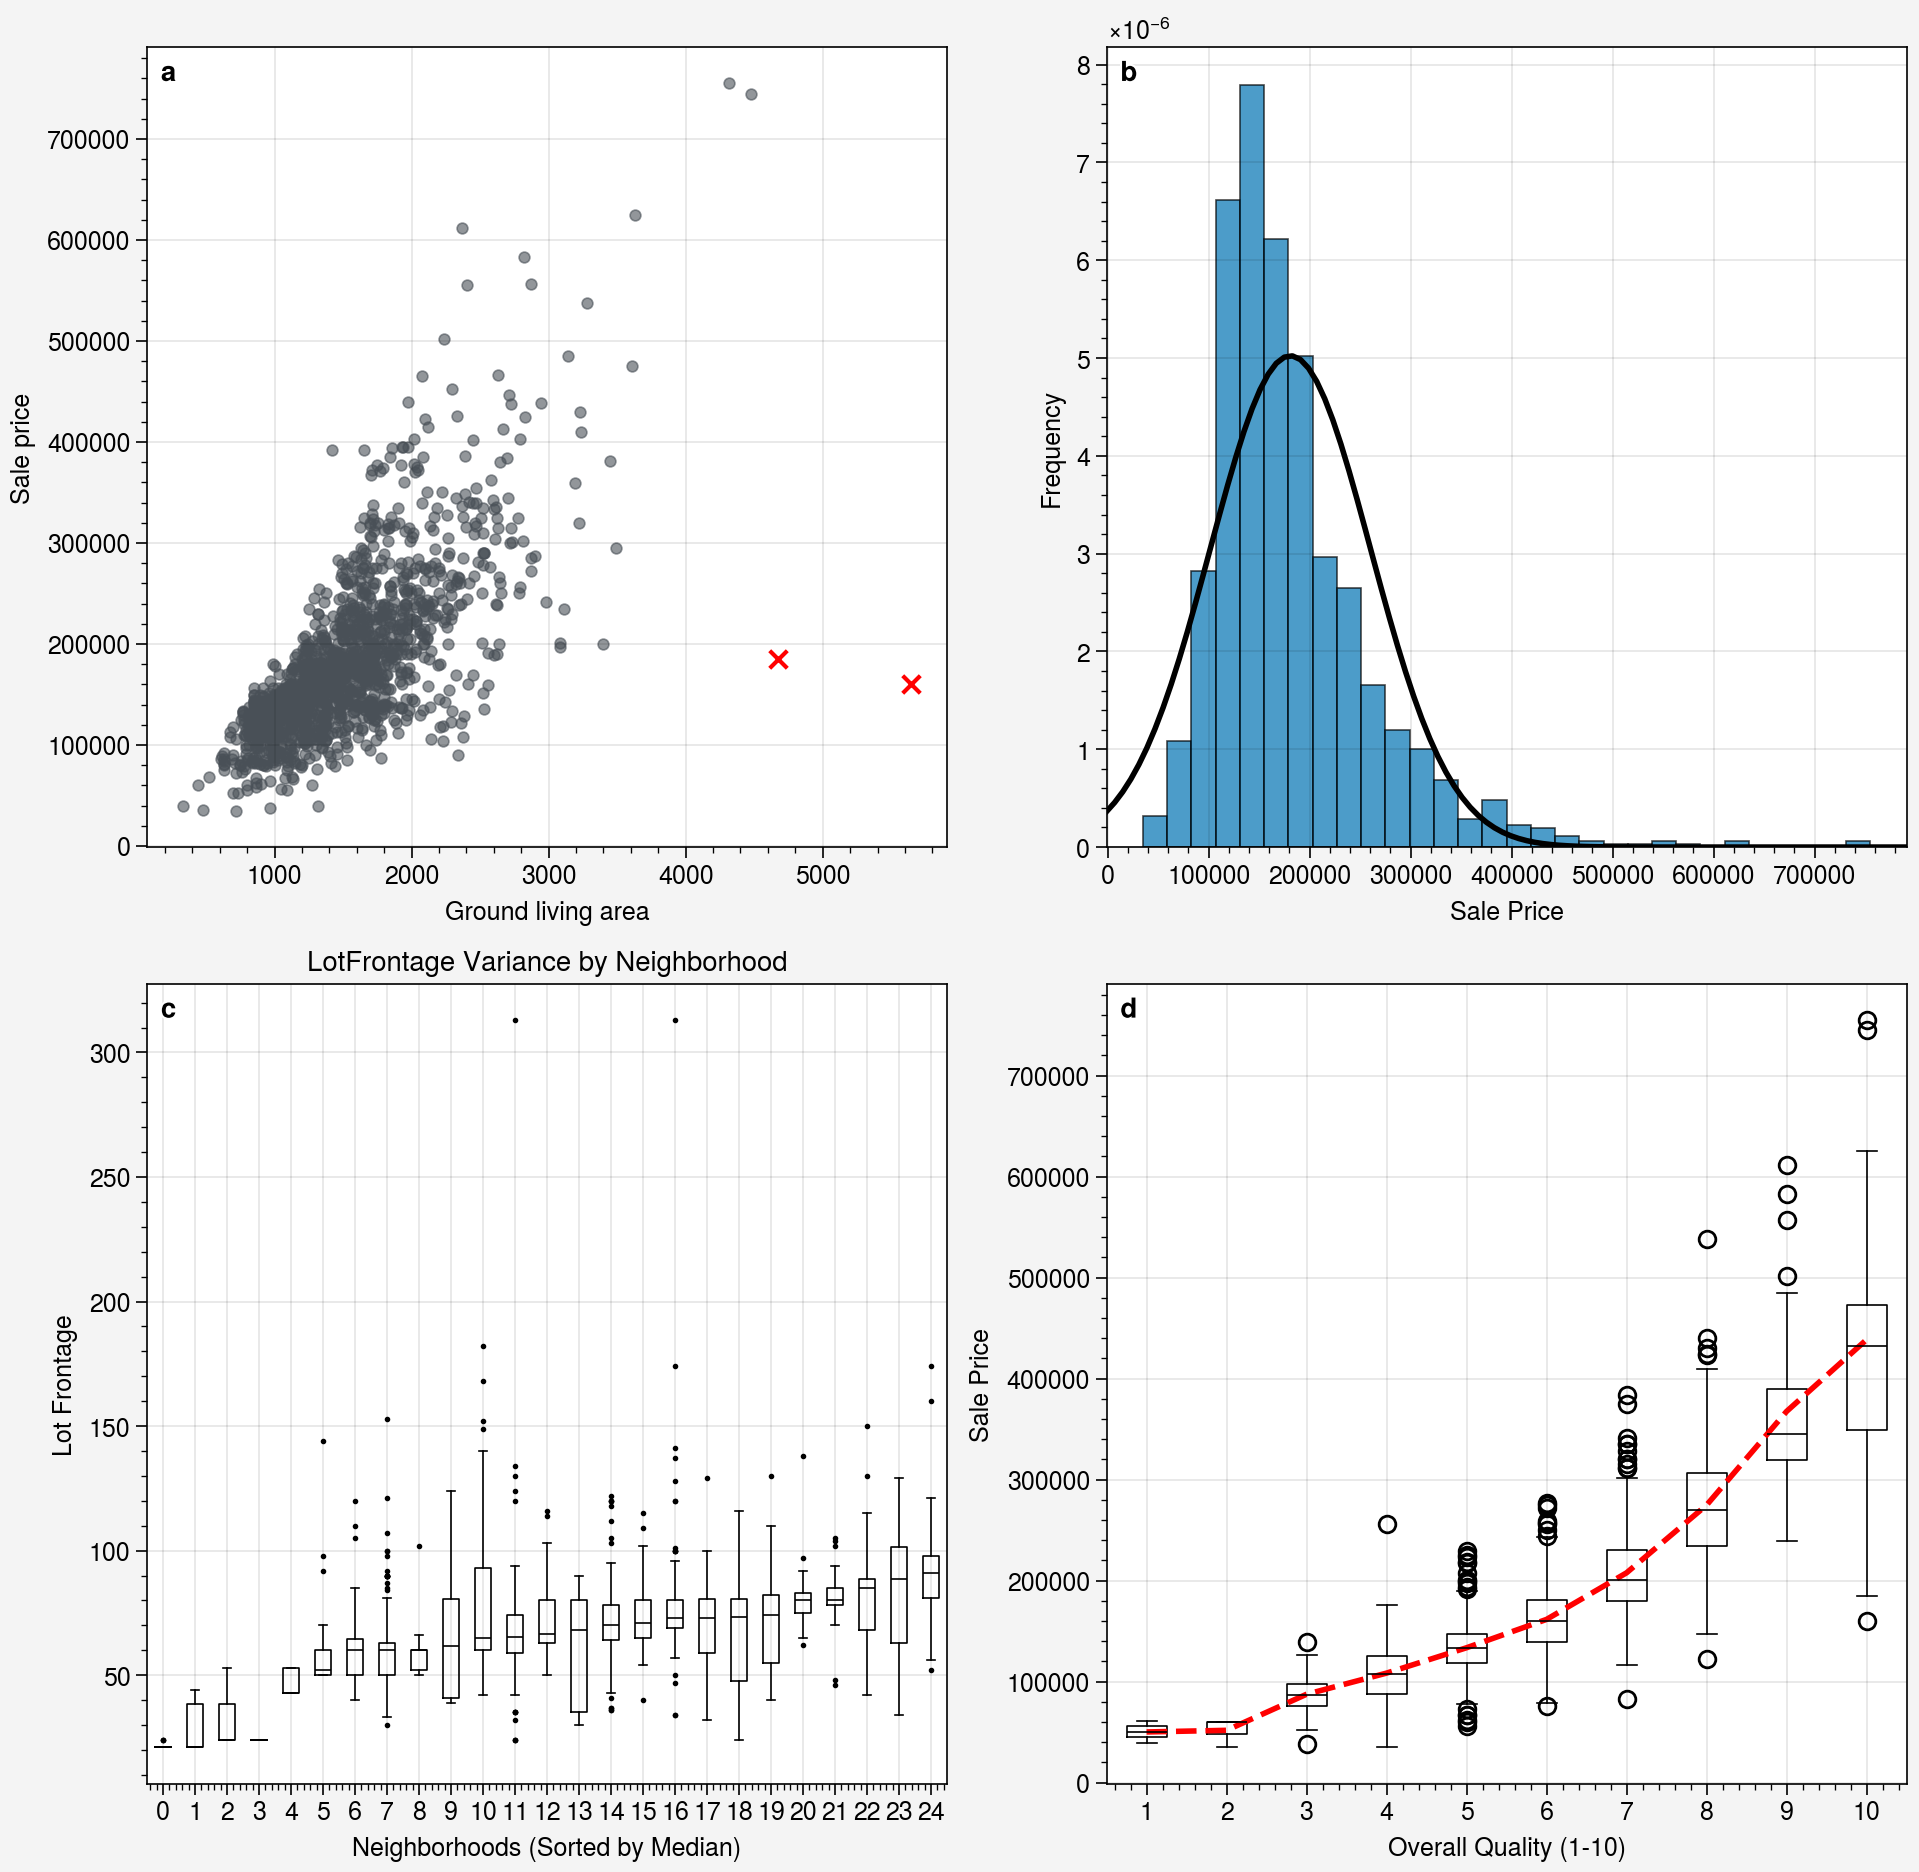

In [ ]:
train=pd.read_csv('train.csv')
fig, axs=uplt.subplots(nrows=2, ncols=2, refwidth=4, share=False)
axs.format(
    abc=True, abcloc='ul' 
)
ax1=axs[0]
n_m=~((train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000))
ax1.scatter(train.loc[n_m, 'GrLivArea'], train.loc[n_m, 'SalePrice'], 
            s=15, alpha=0.6, color='gray7', label='Normal Data')
ax1.scatter(train.loc[~n_m, 'GrLivArea'], train.loc[~n_m, 'SalePrice'], 
            s=40, marker='x', color='red', label='Outliers (Removed)')
ax1.format(xlabel='Ground living area', ylabel='Sale price')
ax2=axs[1]
ax2.hist(train['SalePrice'], bins=30, density=True,  edgecolor='k', alpha=0.7)
xmin, xmax=ax2.get_xlim()
x=np.linspace(xmin, xmax, 100)
p=stats.norm.pdf(x, *stats.norm.fit(train['SalePrice']))
ax2.plot(x, p, 'k', linewidth=2, label='Normal Dist.')
ax2.format( xlabel='Sale Price', ylabel='Frequency')
ax3=axs[2]
neighbororder=train.groupby('Neighborhood')['LotFrontage'].median().sort_values().index
neighbordp=[train[train['Neighborhood'] == n]['LotFrontage'].dropna().values for n in neighbororder]
ax3.boxplot(neighbordp,  marker='.', markersize=2) 
ax3.format(title='LotFrontage Variance by Neighborhood', xlabel='Neighborhoods', ylabel='Lot Frontage')
ax4=axs[3]
qdata=[train[train['OverallQual'] == i]['SalePrice'].values for i in range(1, 11)]
ax4.boxplot(qdata, labels=list(range(1, 11)))
ax4.format(xlabel='Overall Quality', ylabel='Sale Price')
means=train.groupby('OverallQual')['SalePrice'].mean()
ax4.plot(range(0, 10), means.values, color='red', linewidth=2, linestyle='--', label='Mean Trend')

Text(0.5, 1.02, 'Data Quality Analysis → Preprocessing Decisions')

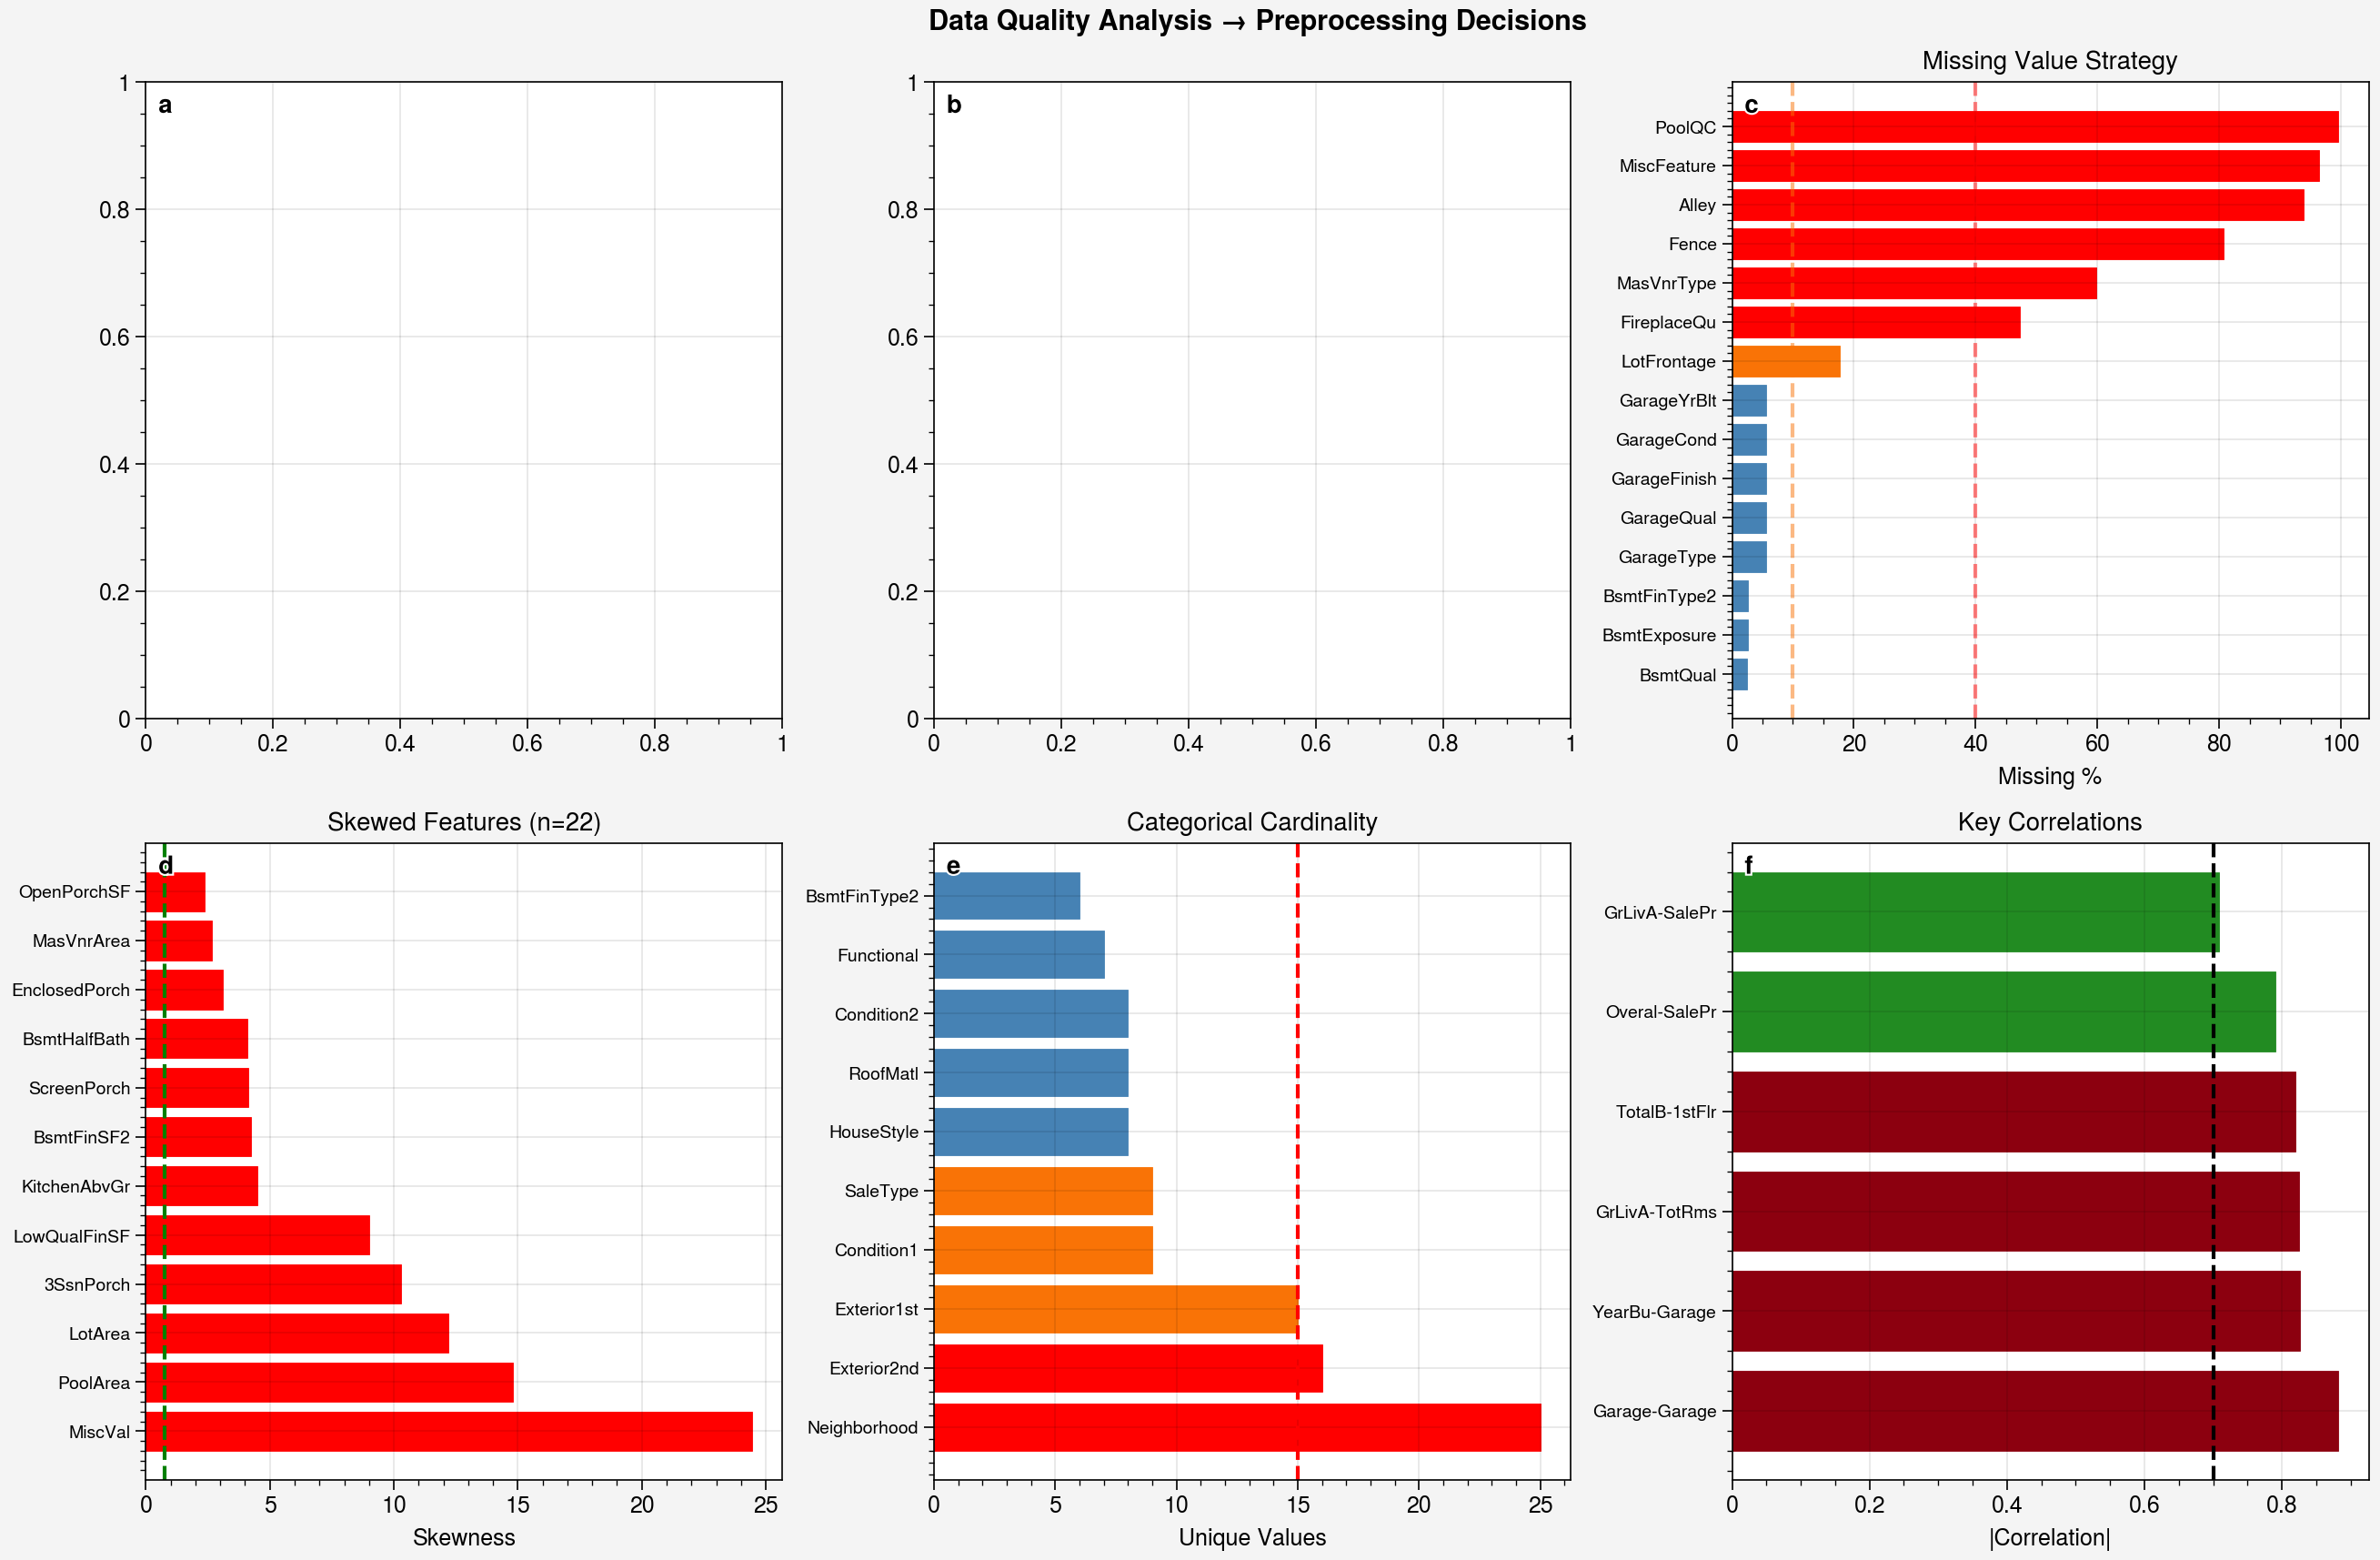

In [ ]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

fig, axs=uplt.subplots(nrows=2, ncols=2, refwidth=3.5, share=False)
axs.format(abc=True, abcloc='ul')


# 1c: 缺失值分析 - 支撑填充策略
ax=axs[0]
missing=train.isnull().sum()
missing=missing[missing > 0].sort_values(ascending=True).tail(15)
colors=['red' if v/len(train) > 0.4 else 'orange' if v/len(train) > 0.1 else 'steelblue' for v in missing.values]
ax.barh(range(len(missing)), missing.values / len(train) * 100, color=colors)
ax.set_yticks(range(len(missing)))
ax.set_yticklabels(missing.index, fontsize=7)
ax.axvline(40, color='red', linestyle='--', alpha=0.5, label='>40%: fillna(None)')
ax.axvline(10, color='orange', linestyle='--', alpha=0.5, label='>10%: group median')
ax.format(xlabel='Missing %', title='Missing Value Strategy')

# 1d: 高偏斜特征 - 支撑Box-Cox决策
ax=axs[1]
num_cols=train.select_dtypes(include=[np.number]).columns
skewness=train[num_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
high_skew=skewness[abs(skewness) > 0.75].head(12)
colors=['red' if s > 2 else 'orange' if s > 1 else 'steelblue' for s in high_skew.values]
ax.barh(range(len(high_skew)), high_skew.values, color=colors)
ax.set_yticks(range(len(high_skew)))
ax.set_yticklabels(high_skew.index, fontsize=7)
ax.axvline(0.75, color='green', linestyle='--', label='BoxCox threshold')
ax.format(xlabel='Skewness', title=f'Skewed Features (n={len(skewness[abs(skewness)>0.75])})')

# 1e: 高基数类别 - 支撑Target Encoding决策
ax=axs[2]
catcol=train.select_dtypes(include='object').columns
cardinality=train[catcol].nunique().sort_values(ascending=False).head(10)
colors=['red' if c > 15 else 'orange' if c > 8 else 'steelblue' for c in cardinality.values]
ax.barh(range(len(cardinality)), cardinality.values, color=colors)
ax.set_yticks(range(len(cardinality)))
ax.set_yticklabels(cardinality.index, fontsize=7)
ax.axvline(15, color='red', linestyle='--', label='>15: Target Enc')
ax.format(xlabel='Unique Values', title='Categorical Cardinality')

# 1f: 高相关特征对 - 支撑特征工程决策
ax=axs[3]
corr_pairs=[('GarageCars', 'GarageArea', 0.882), ('YearBuilt', 'GarageYrBlt', 0.826),
              ('GrLivArea', 'TotRmsAbvGrd', 0.825), ('TotalBsmtSF', '1stFlrSF', 0.820),
              ('OverallQual', 'SalePrice', 0.791), ('GrLivArea', 'SalePrice', 0.709)]
labels=[f'{p[0][:6]}-{p[1][:6]}' for p in corr_pairs]
values=[p[2] for p in corr_pairs]
colors=['forestgreen' if 'SalePrice' in p[0]+p[1] else 'crimson' for p in corr_pairs]
ax.barh(range(len(labels)), values, color=colors)
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels, fontsize=7)
ax.axvline(0.7, color='black', linestyle='--')
ax.format(xlabel='|Correlation|', title='Key Correlations')

fig.suptitle('Data Quality Analysis → Preprocessing Decisions', fontsize=11, y=1.02)

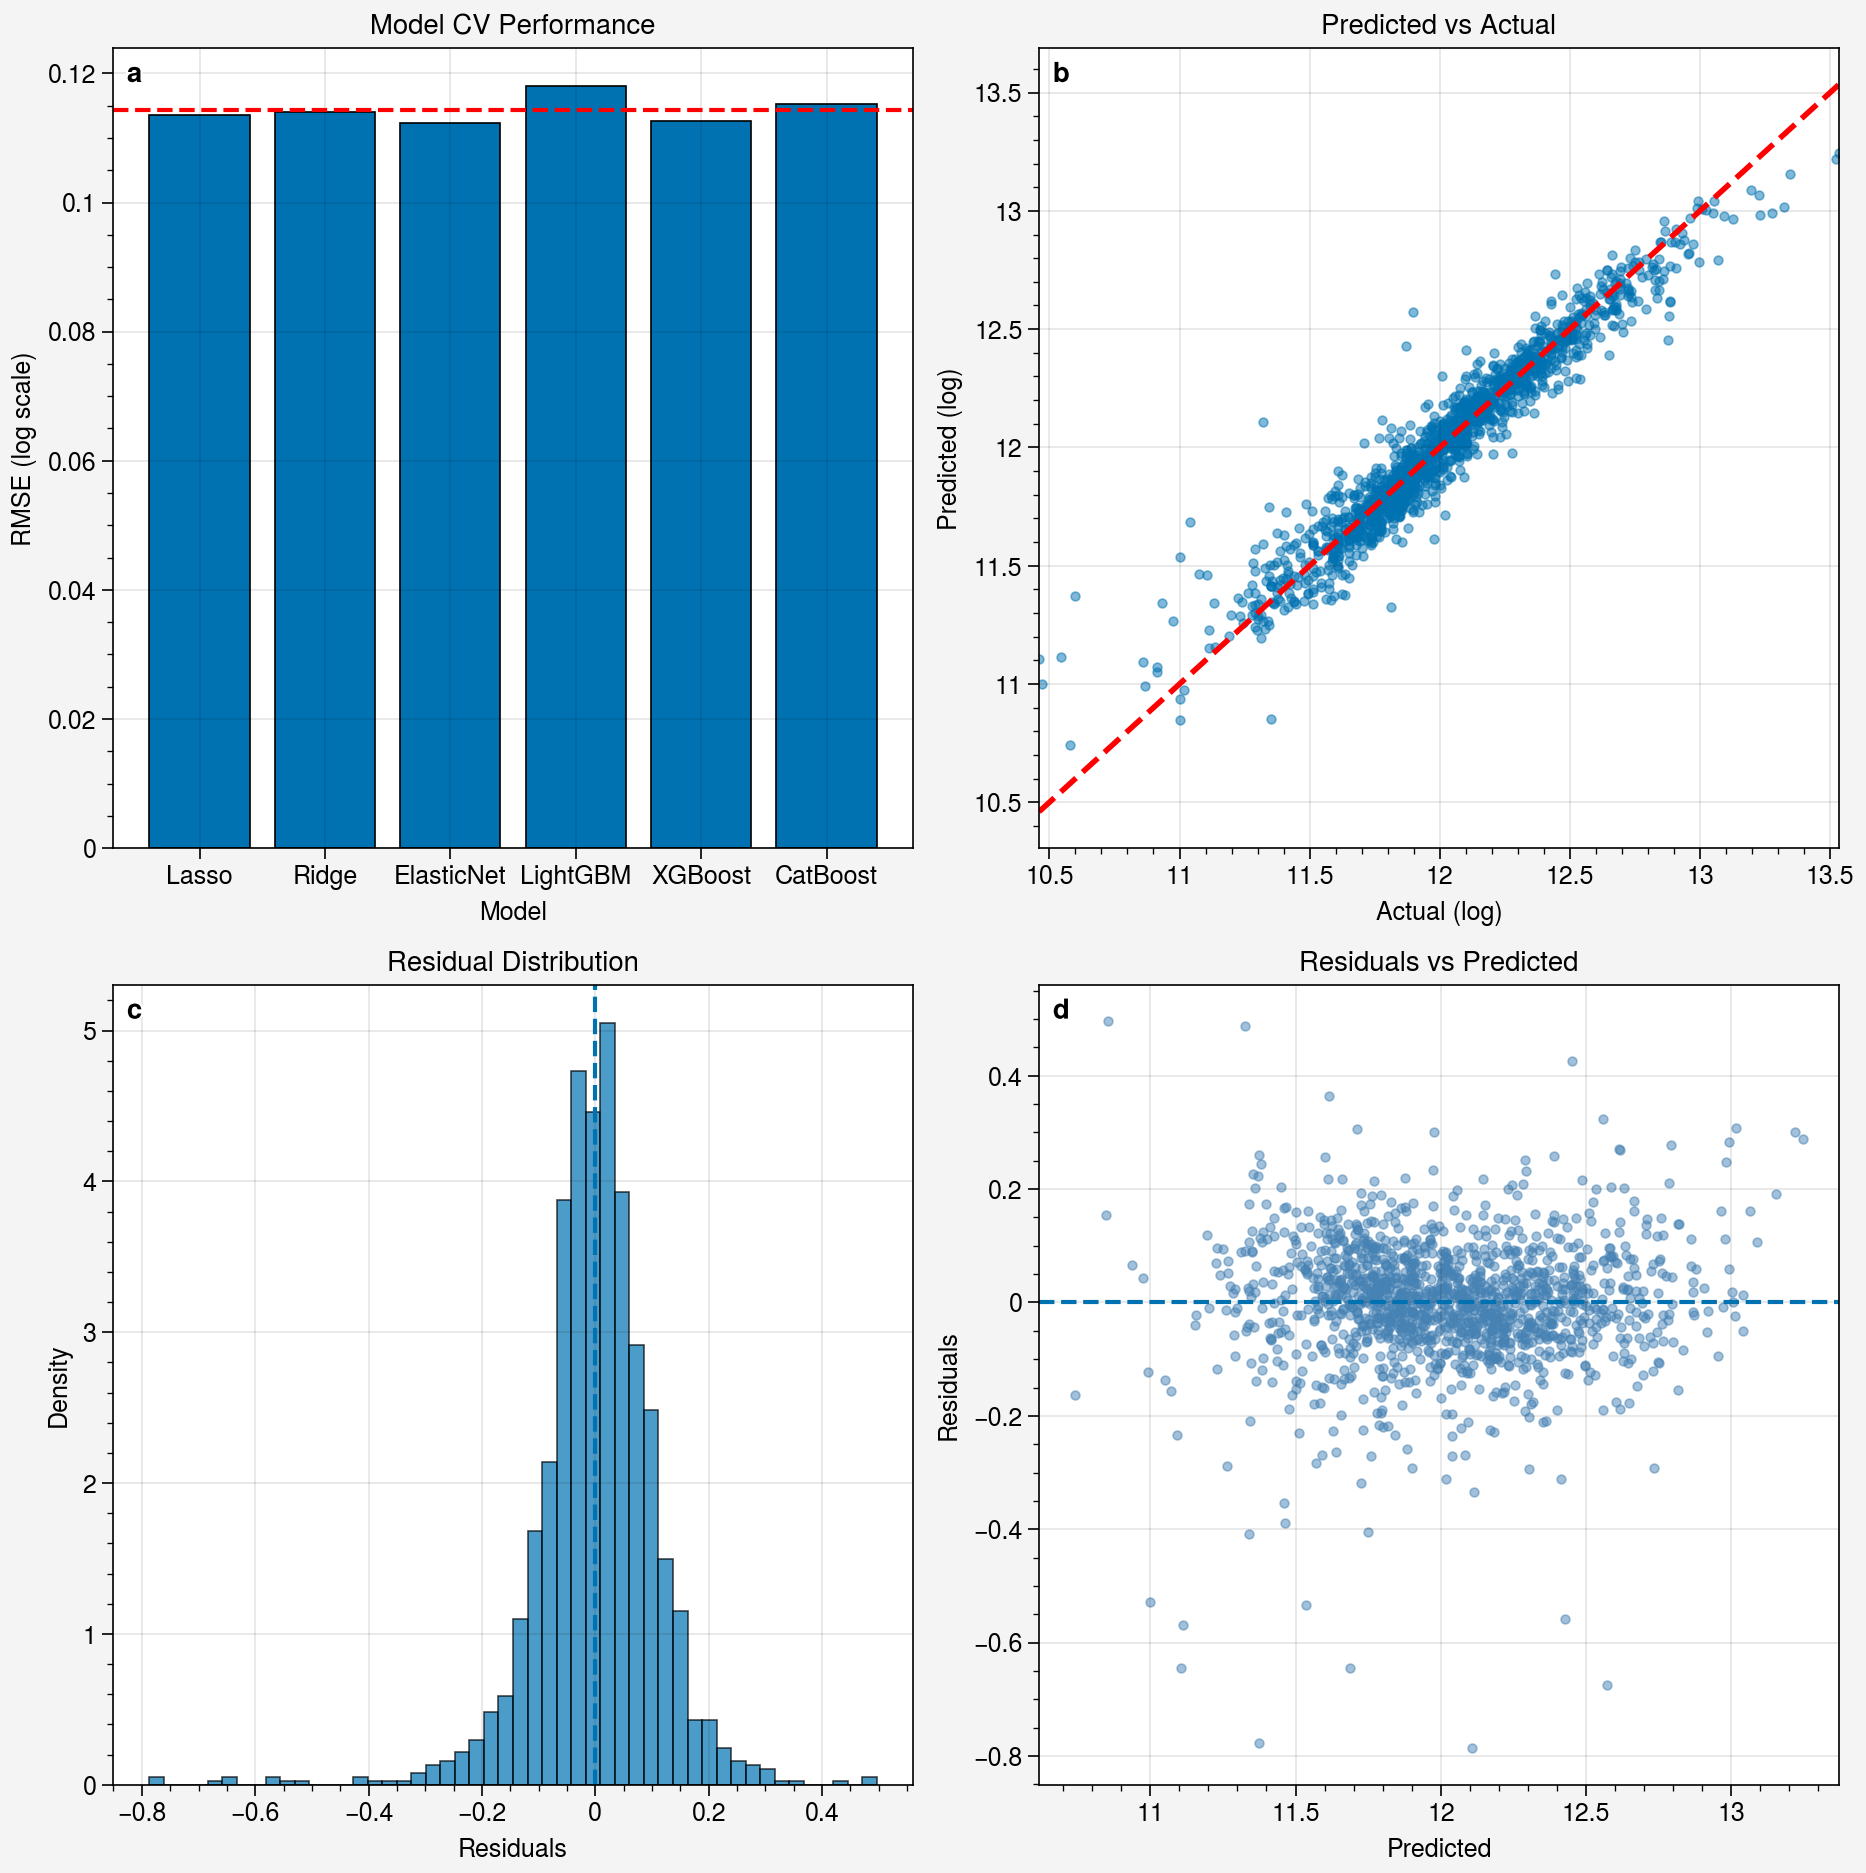

In [ ]:

fig, axs=uplt.subplots(nrows=2, ncols=2, refwidth=4, share=False)
axs.format(abc=True, abcloc='ul')

ax1=axs[0]
modeln=['Lasso', 'Ridge', 'ElasticNet', 'LightGBM', 'XGBoost', 'CatBoost']
CVscore=[np.sqrt(np.mean((ylog - metaT[:, i])**2)) for i in range(6)]
ax1.bar(modeln, CVscore, edgecolor='k')
ax1.format(xlabel='Model', ylabel='RMSE (log scale)', title='Model CV Performance')
ax1.axhline(np.mean(CVscore), color='red', linestyle='--', label='Mean')


ax2=axs[1]
ensemble_pred=sum(w * metaT[:, i] for i, w in enumerate(weights_opt))
ax2.scatter(ylog, ensemble_pred, alpha=0.5, s=10, )
ax2.plot([ylog.min(), ylog.max()], [ylog.min(), ylog.max()], 'r--', linewidth=2)
ax2.format(xlabel='Actual (log)', ylabel='Predicted (log)', title='Predicted vs Actual')


ax3=axs[2]
residuals=ylog - ensemble_pred
ax3.hist(residuals, bins=50, density=True, edgecolor='k', alpha=0.7)
ax3.axvline(0, linestyle='r--')
ax3.format(xlabel='Residuals', ylabel='Density', title='Residual Distribution')

ax4=axs[3]
ax4.scatter(ensemble_pred, residuals, alpha=0.5, s=10, color='steelblue')
ax4.axhline(0,linestyle='r--')
ax4.format(xlabel='Predicted', ylabel='Residuals', title='Residuals vs Predicted')

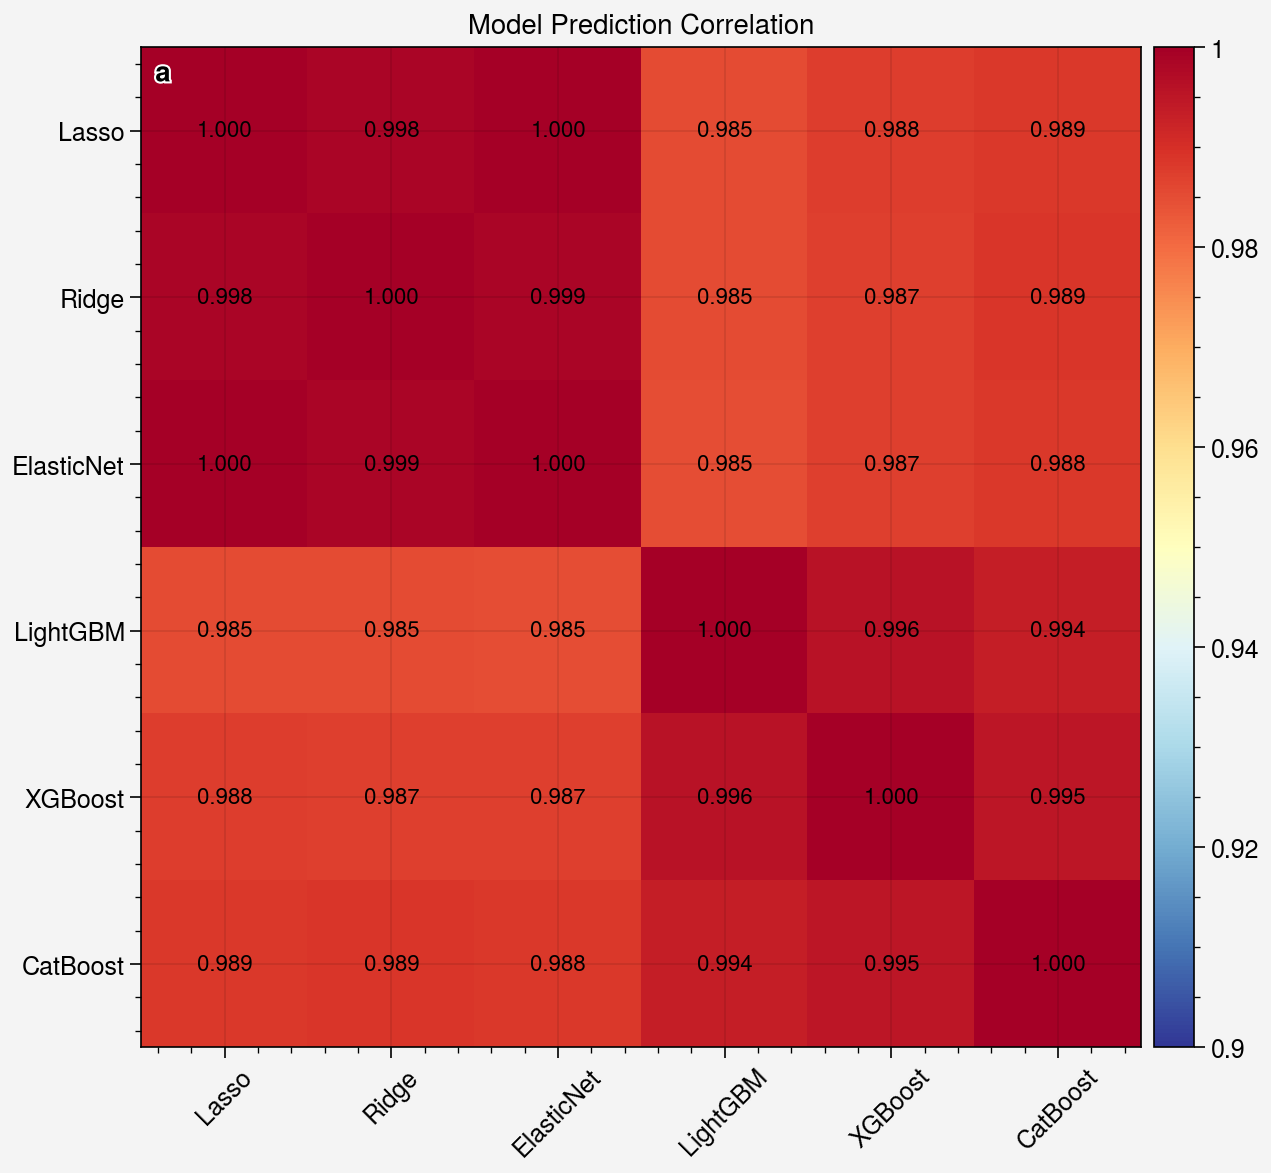

In [24]:
fig, axs=uplt.subplots(nrows=1, ncols=1, refwidth=5, share=False)
axs.format(abc=True, abcloc='ul')
ax1=axs[0]
corr_matrix=pd.DataFrame(metaT, columns=modeln).corr()
im=ax1.imshow(corr_matrix.values, cmap='RdYlBu_r', vmin=0.9, vmax=1)
ax1.set_xticks(range(6))
ax1.set_yticks(range(6))
ax1.set_xticklabels(modeln, rotation=45)
ax1.set_yticklabels(modeln)
for i in range(6):
    for j in range(6):
        ax1.text(j, i, f'{corr_matrix.values[i, j]:.3f}', ha='center', va='center', fontsize=8)
ax1.format(title='Model Prediction Correlation')
fig.colorbar(im, ax=ax1)


C:\Users\wangm\AppData\Local\Temp\ipykernel_26156\845227837.py:143: UltraPlotWarning: Got conflicting or duplicate keyword arguments: {'positions_positional': [[np.float64(0.1128172142942573), np.float64(0.11387035902735397), np.float64(0.12066071533111918), np.float64(0.11650916115650024), np.float64(0.10307717003950936)], [np.float64(0.11538171352948956), np.float64(0.11287566149330389), np.float64(0.12218468424226395), np.float64(0.11826397792525038), np.float64(0.10005557151345267)], [np.float64(0.11035496821004895), np.float64(0.11291757806633804), np.float64(0.1202452676464743), np.float64(0.11534350736837731), np.float64(0.10201445818362265)], [np.float64(0.12272191126206582), np.float64(0.10913148196961966), np.float64(0.1222726034503778), np.float64(0.12833312533781738), np.float64(0.10614680626730079)], [np.float64(0.11484941896465234), np.float64(0.10942358049563691), np.float64(0.11894308549441697), np.float64(0.11733988667189288), np.float64(0.10135918097991321)], [np.floa

Text(0.5, 1.02, 'Deep Diagnostic: Underfitting & Overfitting Analysis')

c:\Anaconda3\envs\intern\Lib\site-packages\ultraplot\axes\base.py:3190: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) TeX Gyre Heros.
  super().draw(renderer, *args, **kwargs)
c:\Anaconda3\envs\intern\Lib\site-packages\ultraplot\axes\base.py:3190: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) TeX Gyre Heros.
  super().draw(renderer, *args, **kwargs)
c:\Anaconda3\envs\intern\Lib\site-packages\ultraplot\axes\base.py:3190: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) TeX Gyre Heros.
  super().draw(renderer, *args, **kwargs)


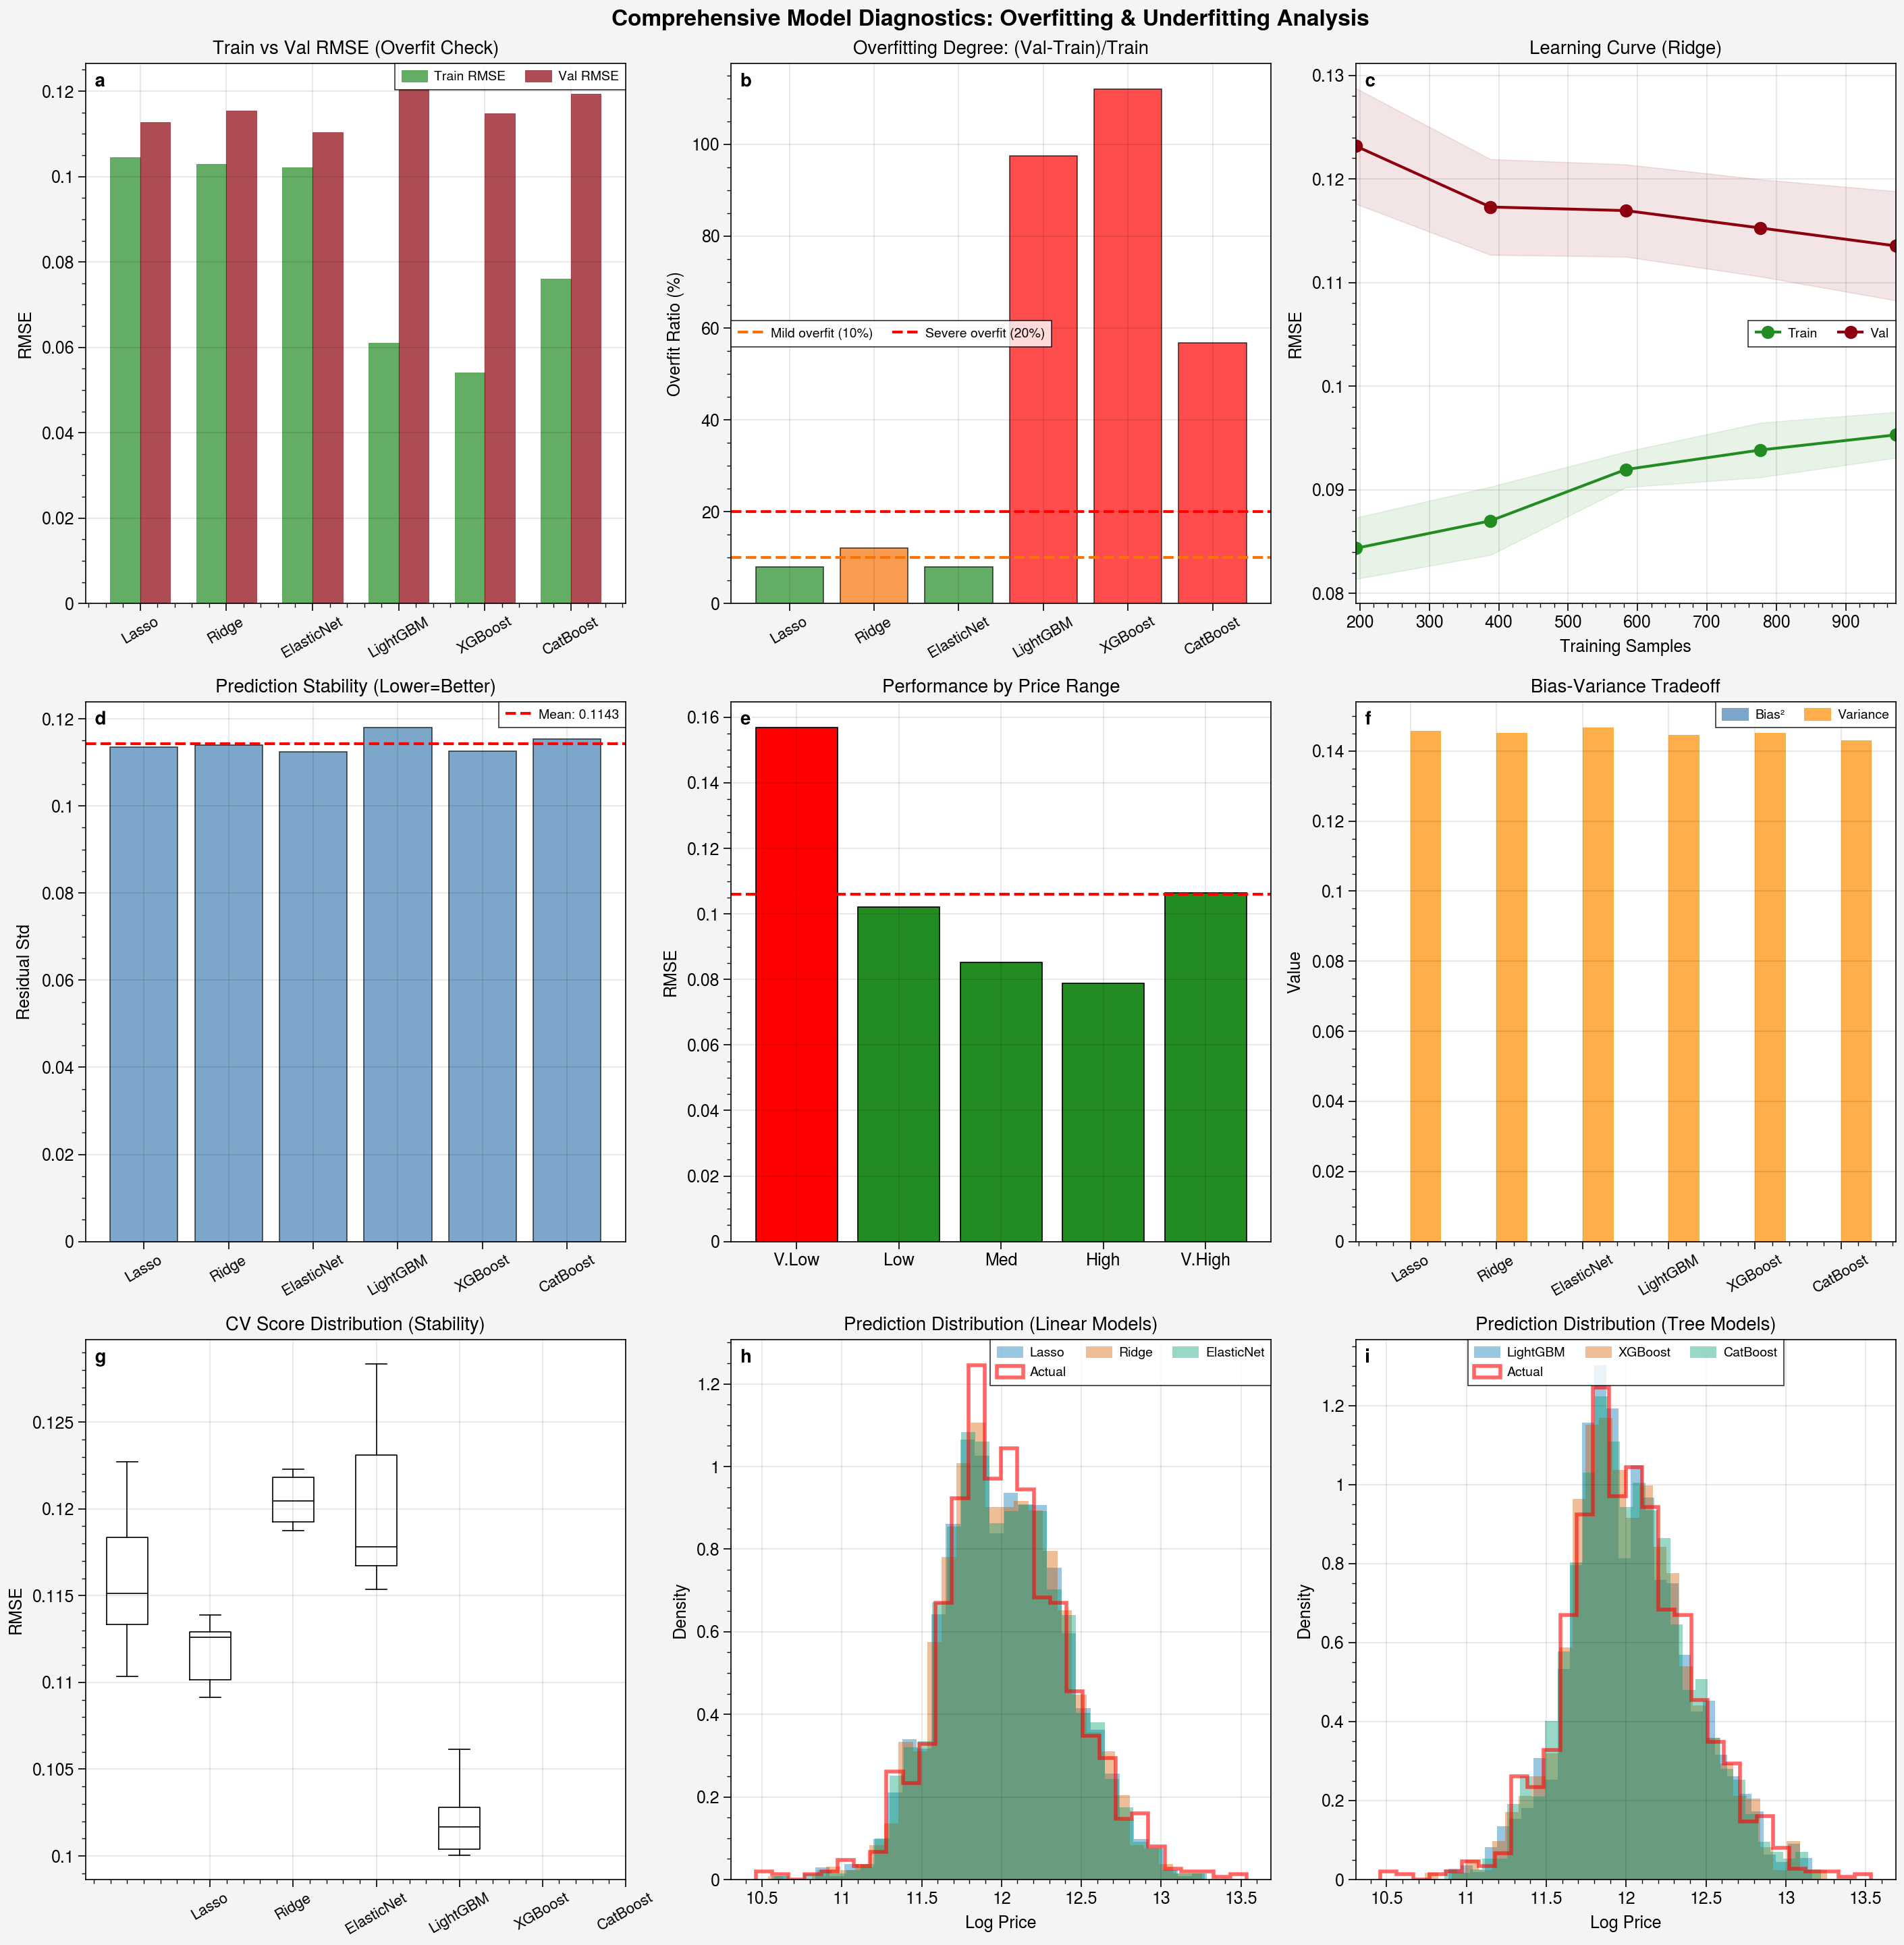

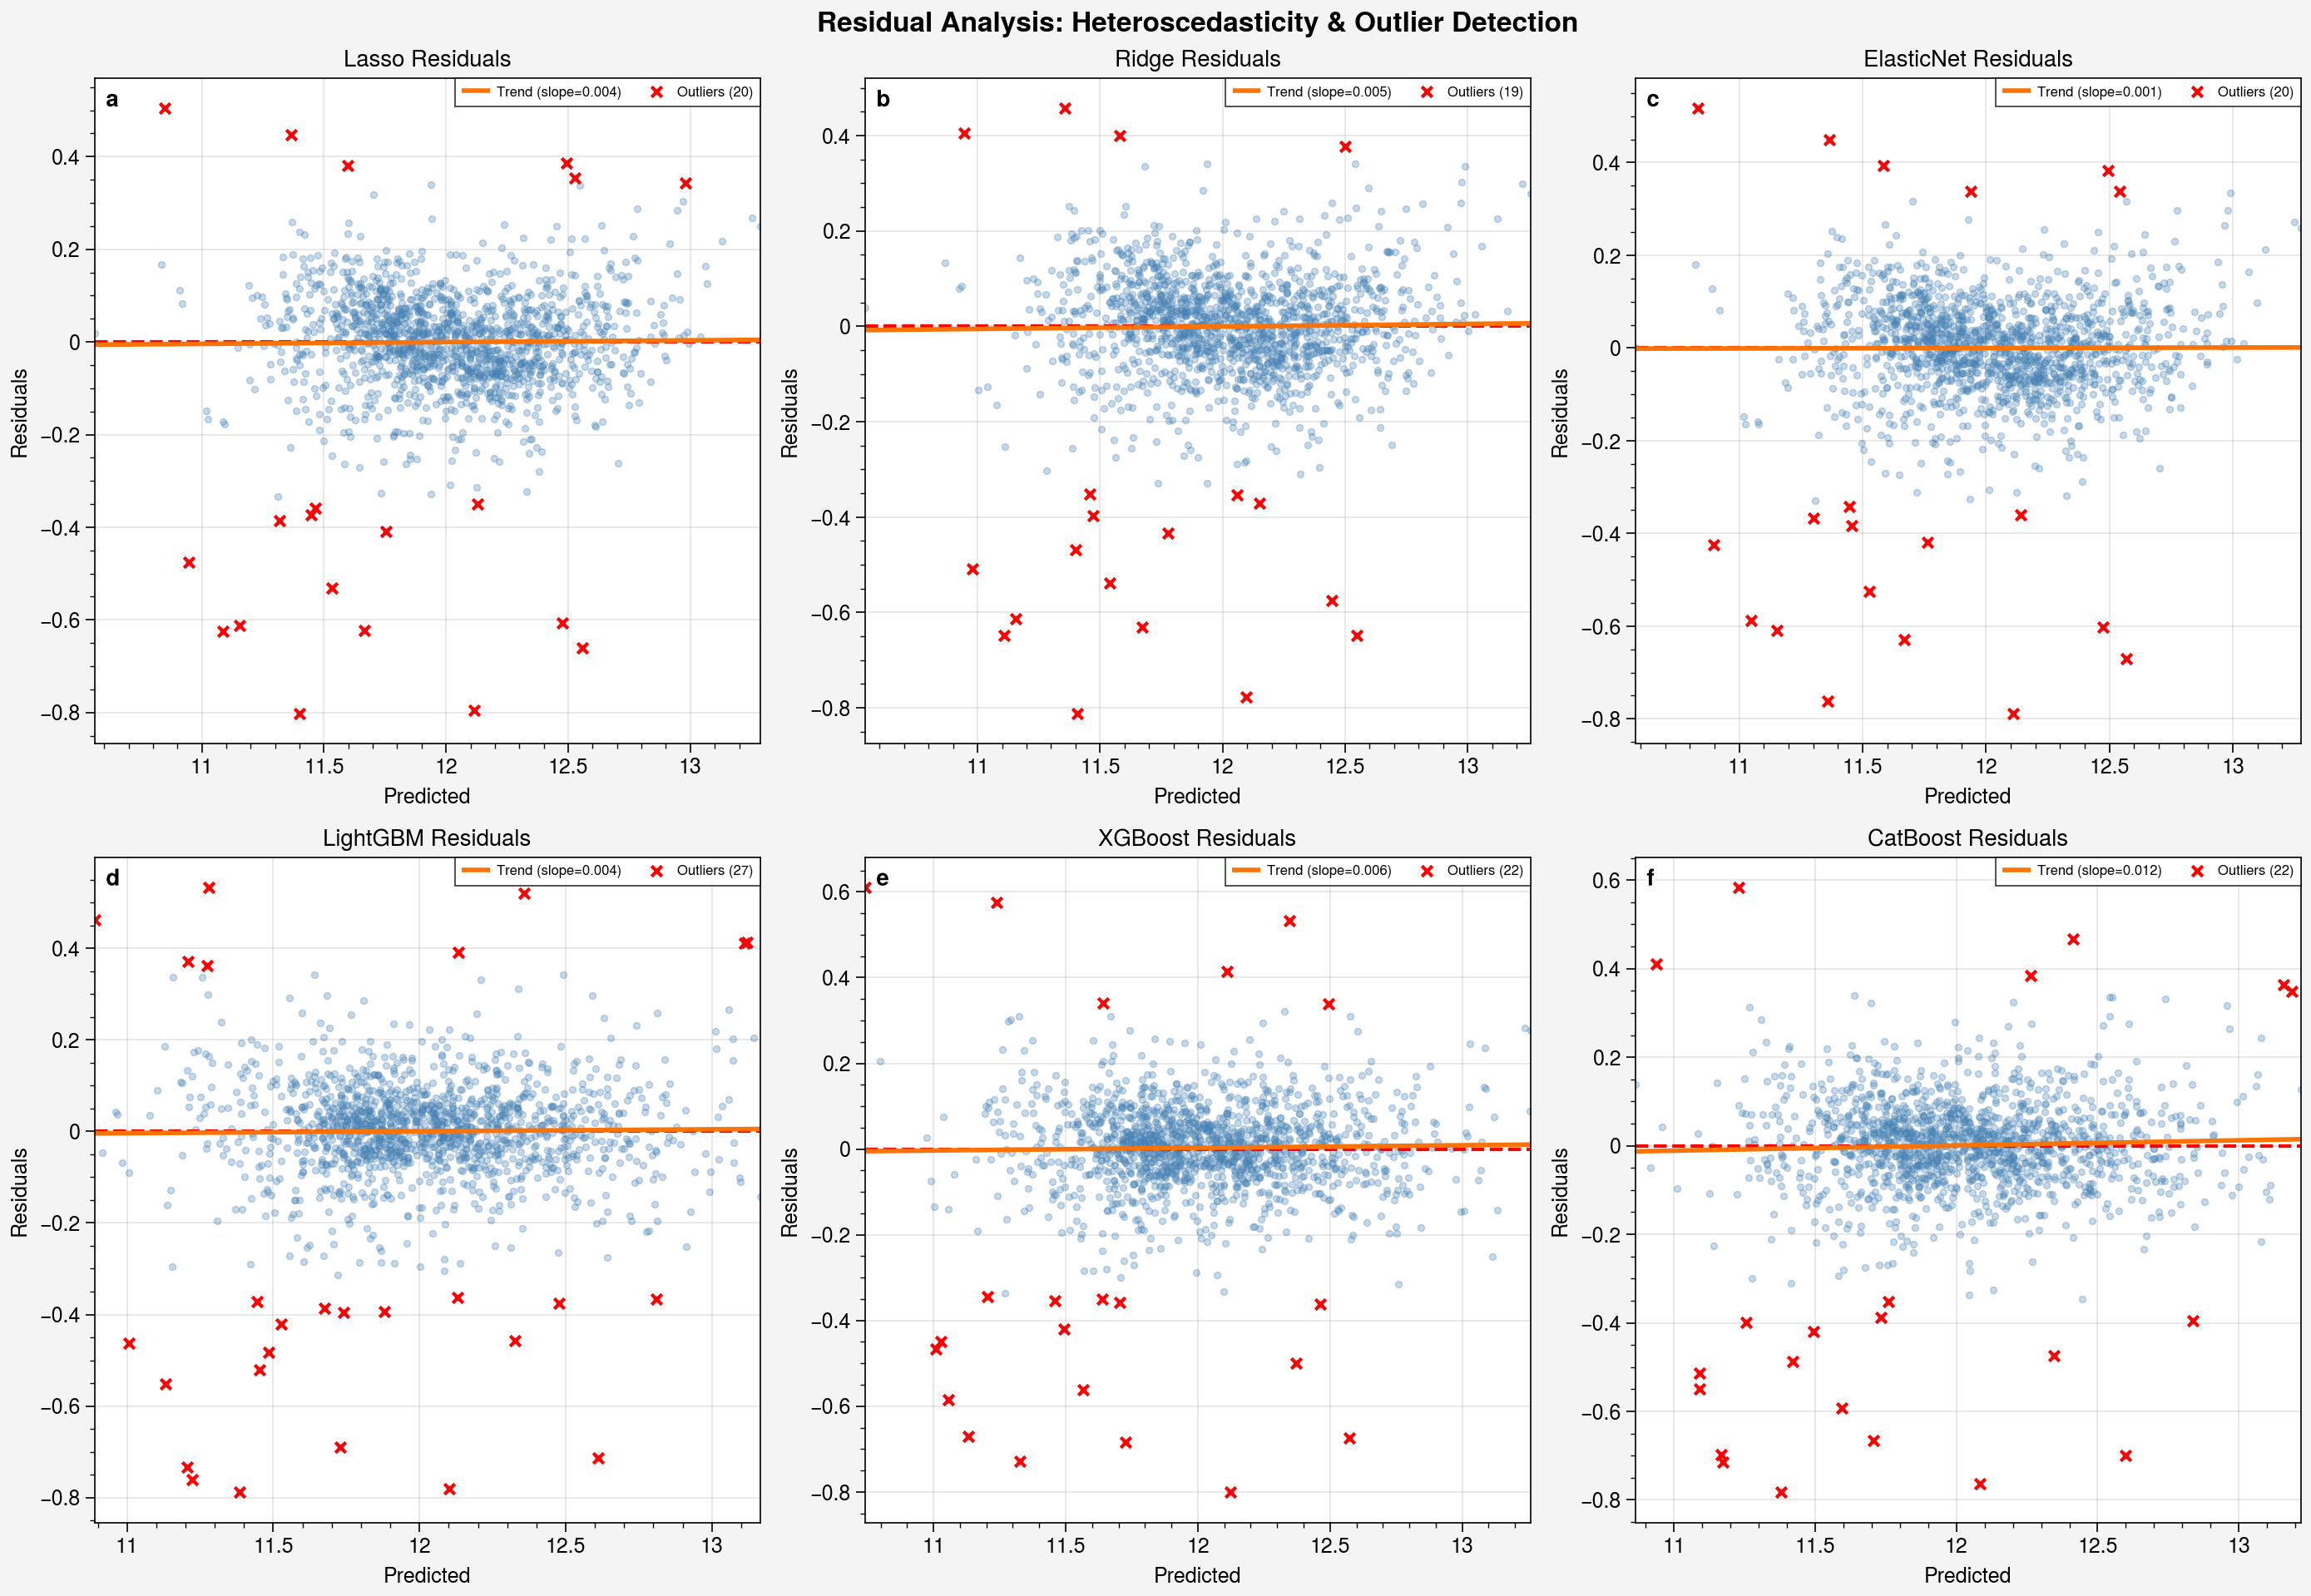

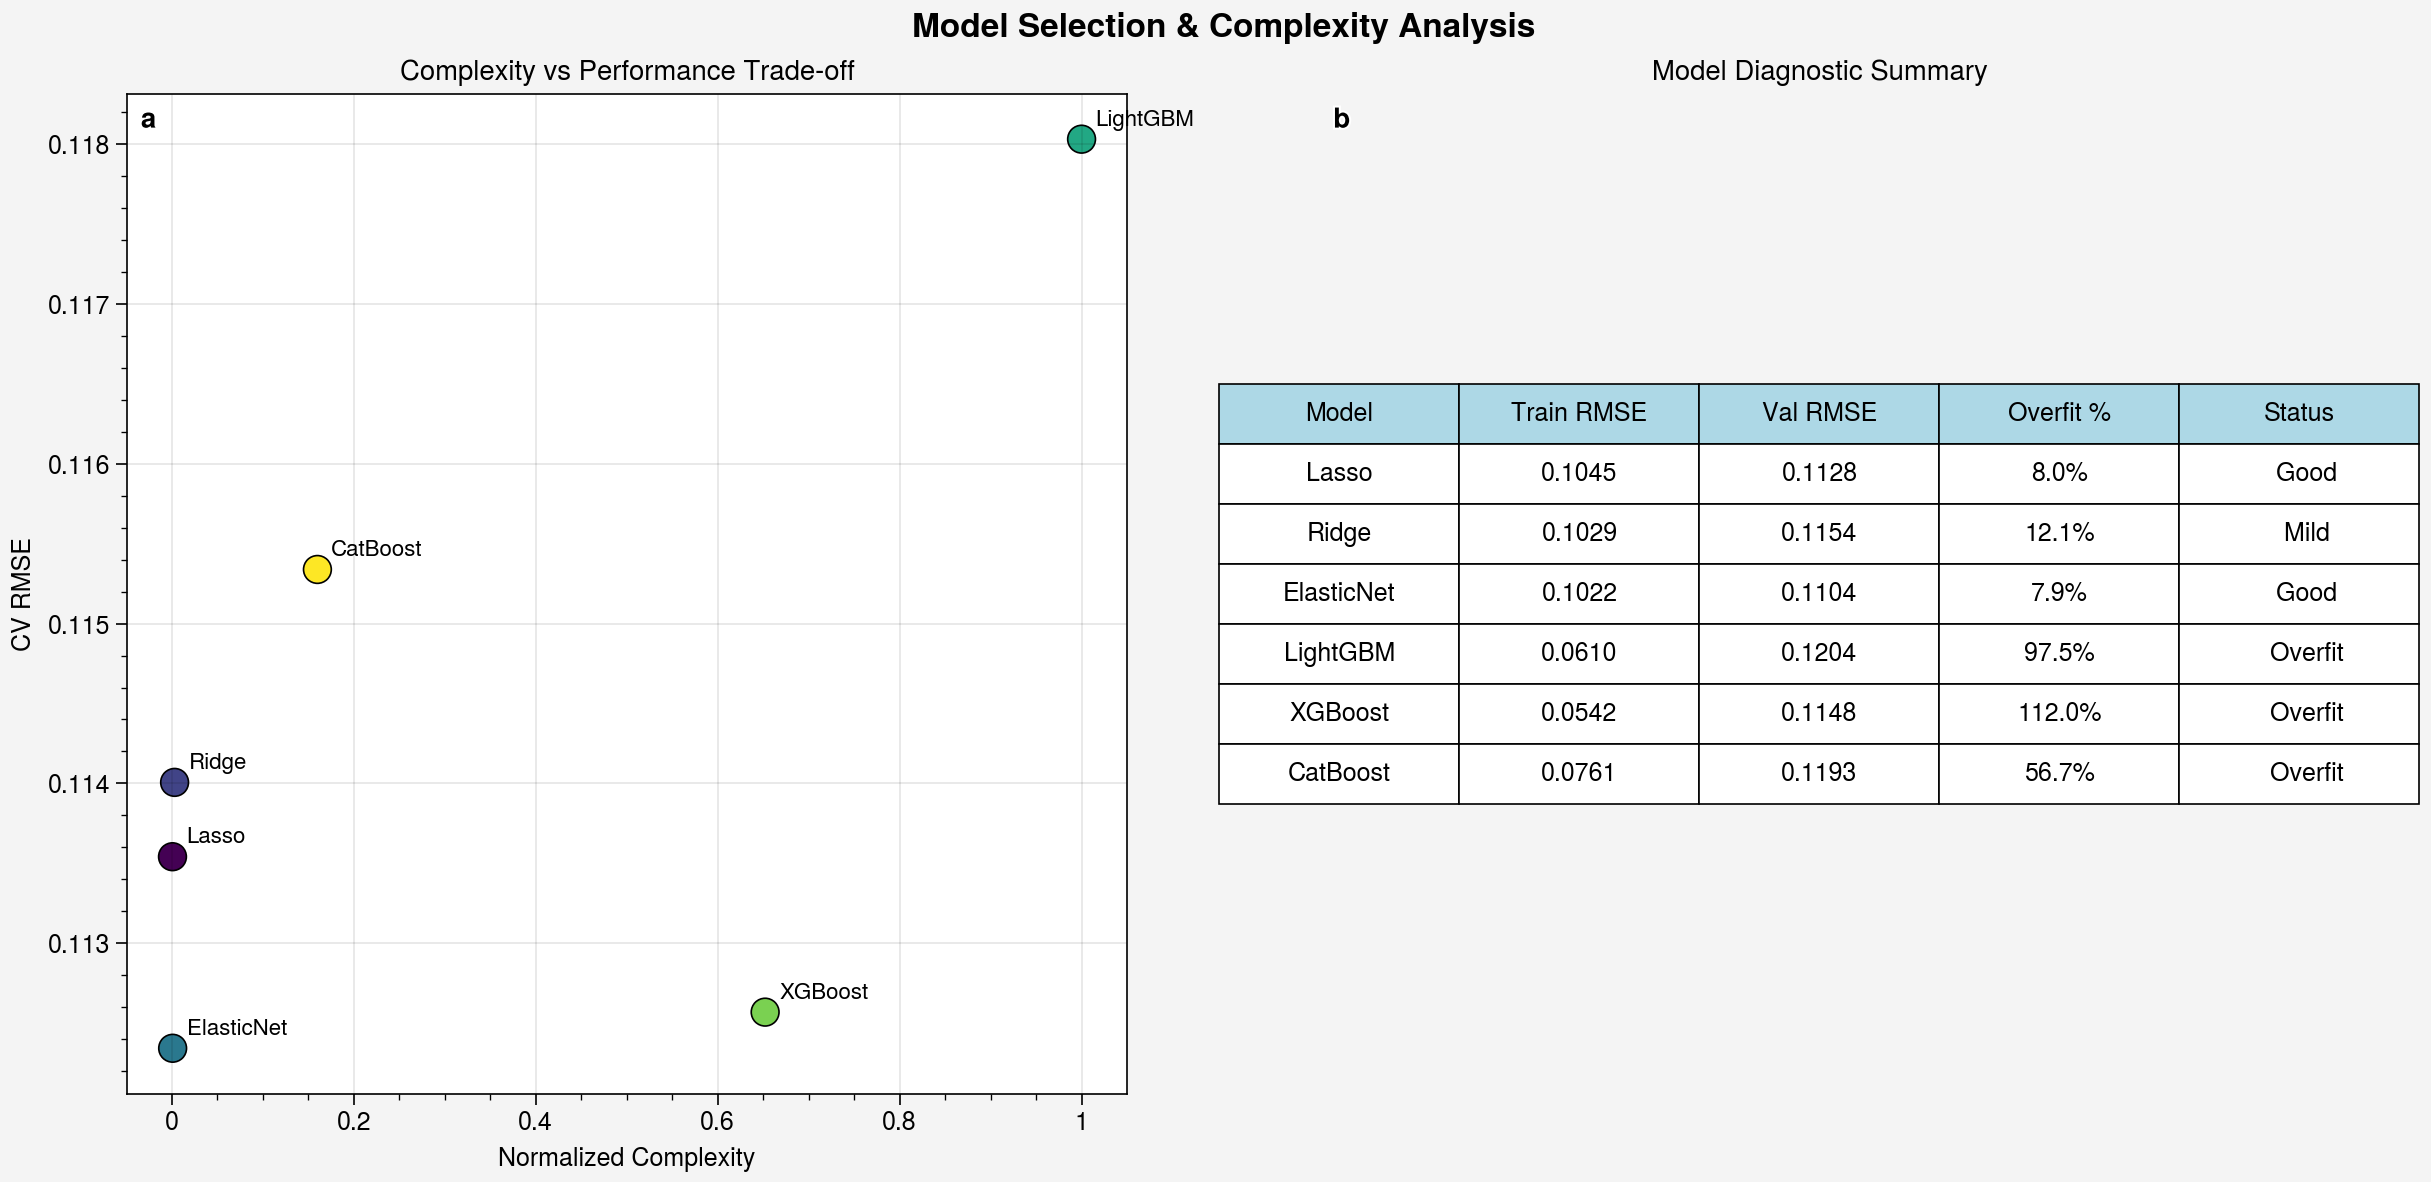

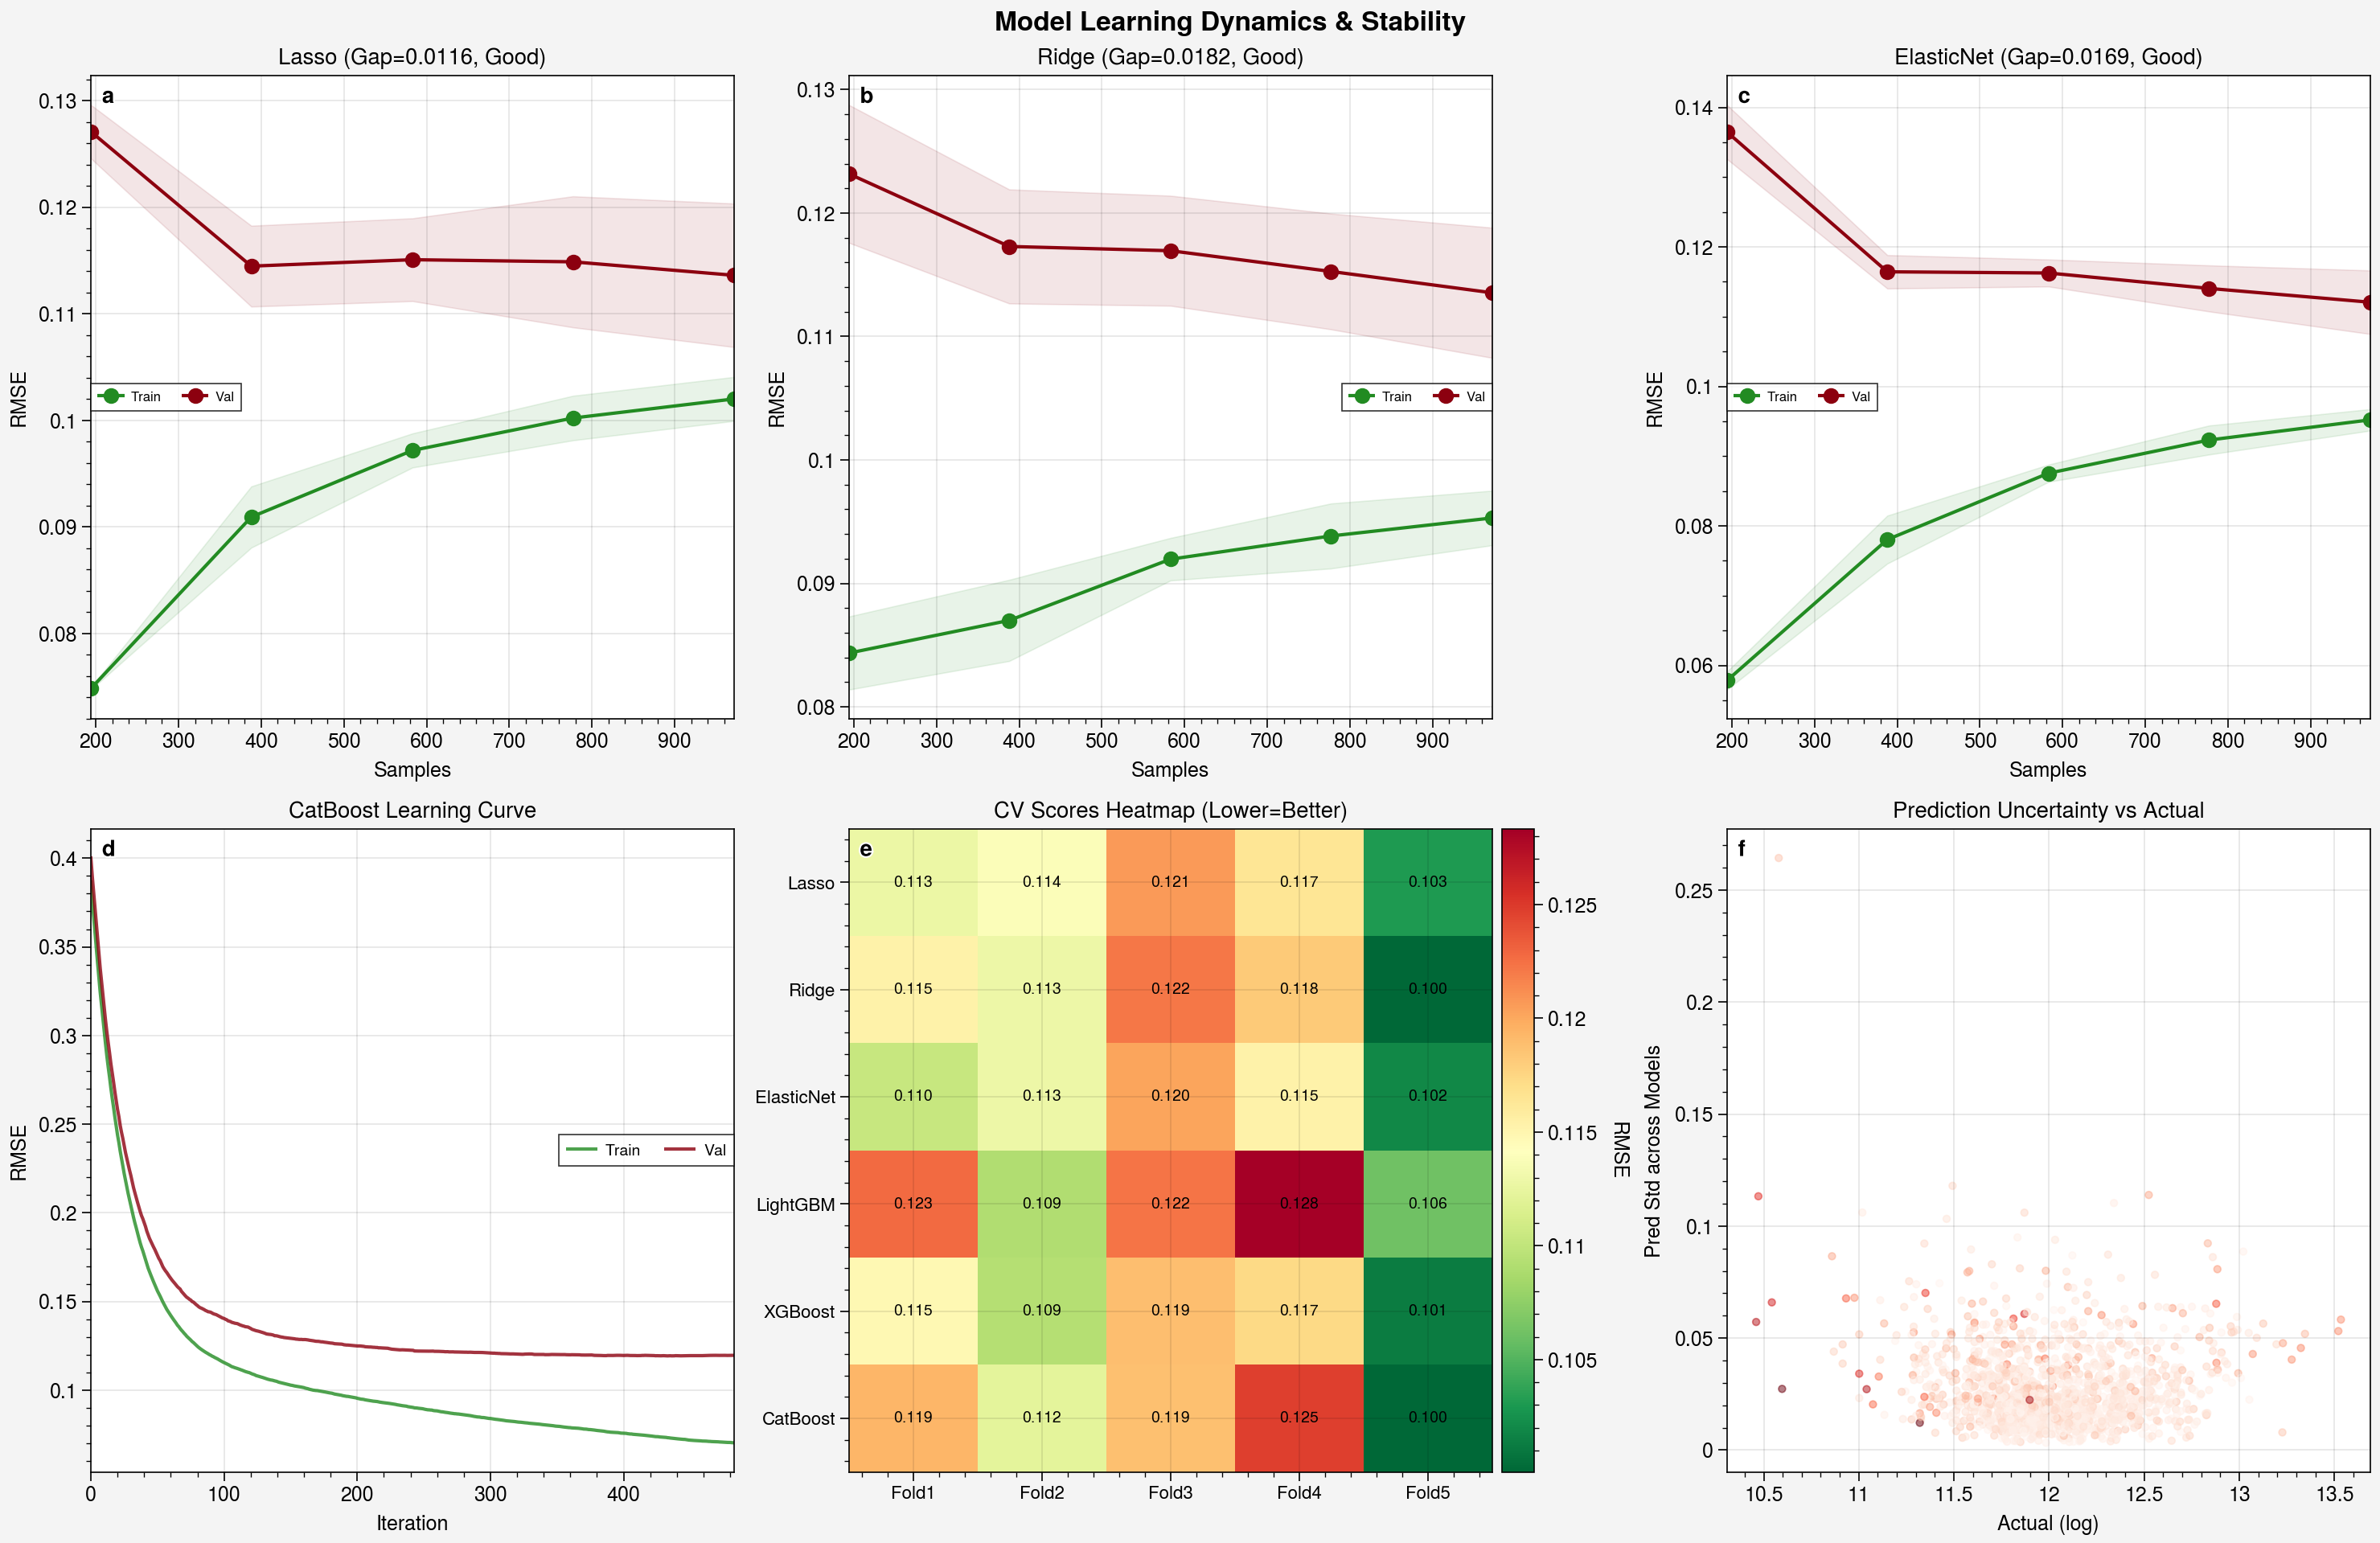

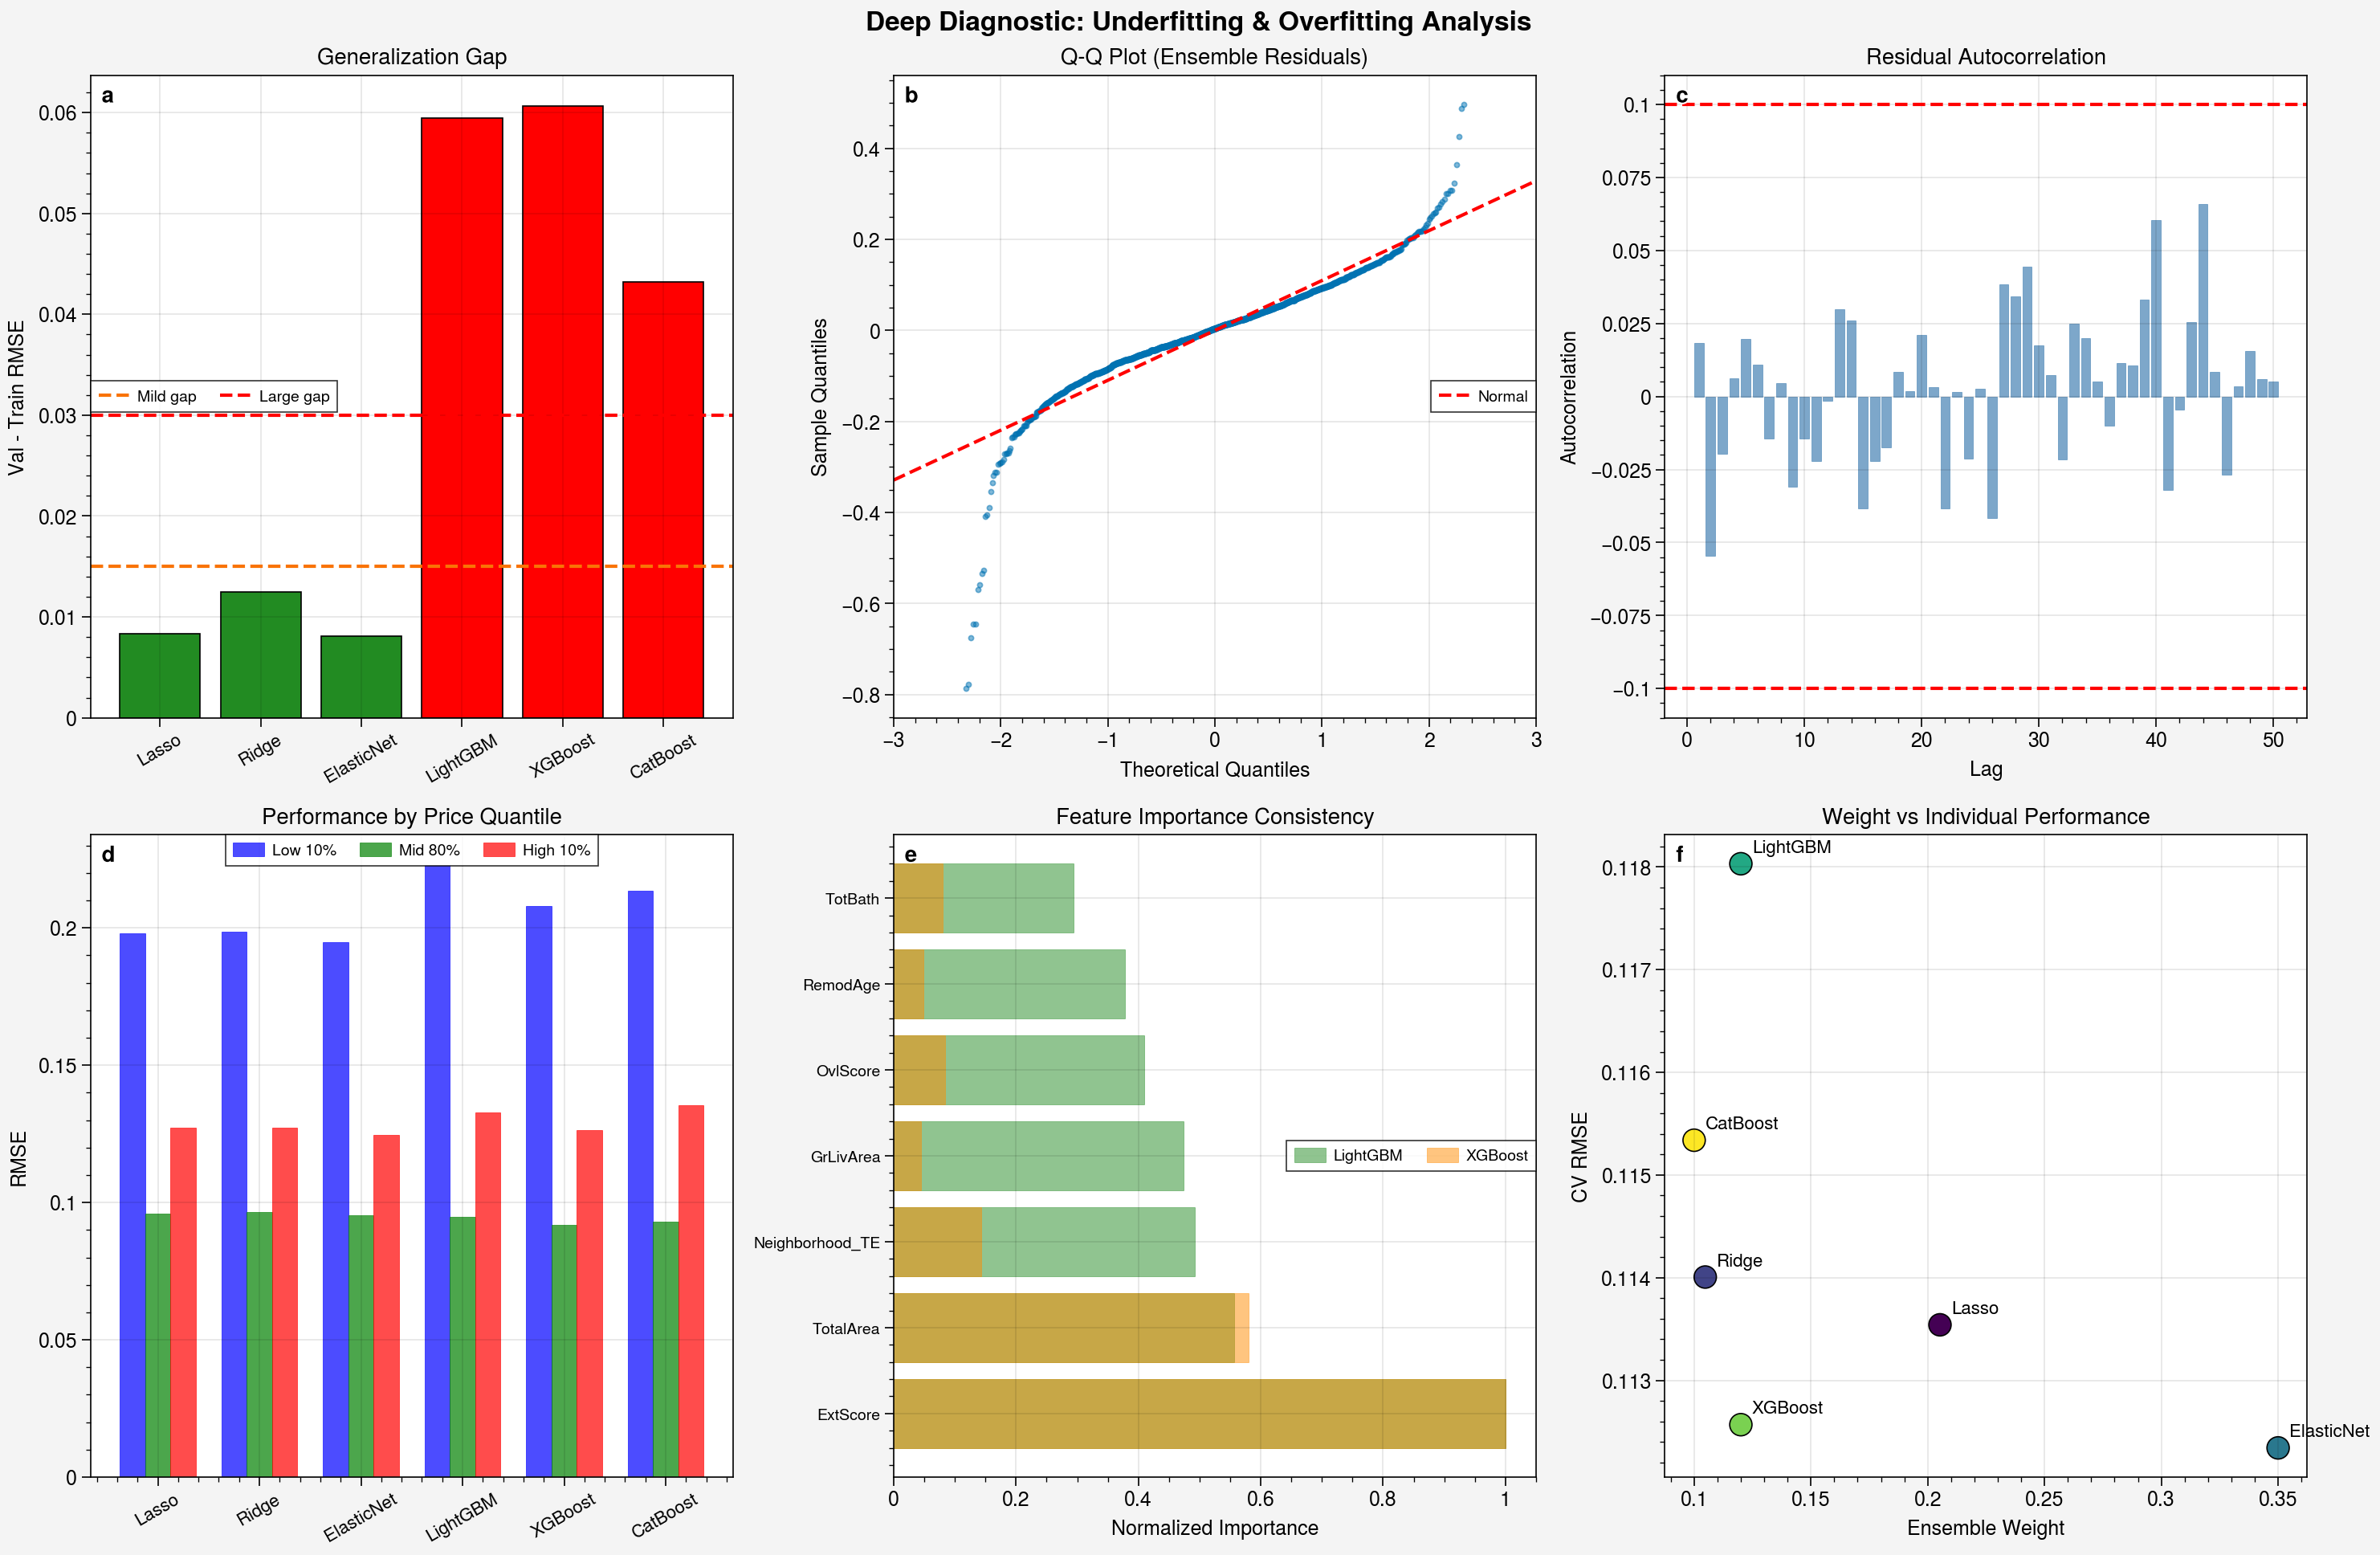

In [ ]:

fig, axs=uplt.subplots(nrows=3, ncols=3, refwidth=4, share=False)
axs.format(abc=True, abcloc='ul')

modeln=['Lasso', 'Ridge', 'ElasticNet', 'LightGBM', 'XGBoost', 'CatBoost']

ax=axs[0]
train_rmse=[]
val_rmse=[]

for fold_idx, (trainid, valid) in enumerate(kf.split(XcXGB)):
    if fold_idx == 0:  
        ytr, yval=ylog.iloc[trainid], ylog.iloc[valid]

        Xtrs, X_val_s=XcleanSCA[trainid], XcleanSCA[valid]
        
        lasso.fit(Xtrs, ytr)
        train_rmse.append(np.sqrt(np.mean((ytr - lasso.predict(Xtrs))**2)))
        val_rmse.append(np.sqrt(np.mean((yval - lasso.predict(X_val_s))**2)))
        
        ridge.fit(Xtrs, ytr)
        train_rmse.append(np.sqrt(np.mean((ytr - ridge.predict(Xtrs))**2)))
        val_rmse.append(np.sqrt(np.mean((yval - ridge.predict(X_val_s))**2)))
        
        elasticnet.fit(Xtrs, ytr)
        train_rmse.append(np.sqrt(np.mean((ytr - elasticnet.predict(Xtrs))**2)))
        val_rmse.append(np.sqrt(np.mean((yval - elasticnet.predict(X_val_s))**2)))

        Xtrlgbm, Xvallgbm=Xclg.iloc[trainid], Xclg.iloc[valid]
        Xtrxgb, Xvalxgb=XcXGB.iloc[trainid], XcXGB.iloc[valid]
        
        lgbm.fit(Xtrlgbm, ytr)
        train_rmse.append(np.sqrt(np.mean((ytr - lgbm.predict(Xtrlgbm))**2)))
        val_rmse.append(np.sqrt(np.mean((yval - lgbm.predict(Xvallgbm))**2)))
        
        xgb.fit(Xtrxgb, ytr, eval_set=[(Xvalxgb, yval)], verbose=False)
        train_rmse.append(np.sqrt(np.mean((ytr - xgb.predict(Xtrxgb))**2)))
        val_rmse.append(np.sqrt(np.mean((yval - xgb.predict(Xvalxgb))**2)))
        
        cat.fit(Xtrlgbm, ytr, eval_set=(Xvallgbm, yval), verbose=False)
        train_rmse.append(np.sqrt(np.mean((ytr - cat.predict(Xtrlgbm))**2)))
        val_rmse.append(np.sqrt(np.mean((yval - cat.predict(Xvallgbm))**2)))

x=np.arange(len(modeln))
width=0.35
ax.bar(x - width/2, train_rmse, width, label='Train RMSE', color='forestgreen', alpha=0.7)
ax.bar(x + width/2, val_rmse, width, label='Val RMSE', color='crimson', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(modeln, rotation=30, fontsize=8)
ax.format(ylabel='RMSE', title='Train vs Val RMSE')
ax.legend(fontsize=7)

ax=axs[1]
overfit_ratio=[(v - t) / t * 100 for t, v in zip(train_rmse, val_rmse)]
colors=['red' if r > 20 else 'orange' if r > 10 else 'forestgreen' for r in overfit_ratio]
ax.bar(modeln, overfit_ratio, color=colors, edgecolor='k', alpha=0.7)
ax.axhline(10, color='orange', linestyle='--', label='Mild overfit (10%)')
ax.axhline(20, color='red', linestyle='--', label='Severe overfit (20%)')
ax.set_xticklabels(modeln, rotation=30, fontsize=8)
ax.format(ylabel='Overfit Ratio (%)')
ax.legend(fontsize=7)

ax=axs[2]


Tsize=np.linspace(0.2, 1.0, 5)
Trainabs, trainscores, val_scores=learning_curve(
    Ridge(alpha=ridge_cv.alpha_), XcleanSCA, ylog, 
    train_sizes=Tsize, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1
)
ax.plot(Trainabs, -trainscores.mean(axis=1), 'o-', label='Train', color='forestgreen')
ax.plot(Trainabs, -val_scores.mean(axis=1), 'o-', label='Val', color='crimson')
ax.fill_between(Trainabs, -trainscores.mean(axis=1) - trainscores.std(axis=1),
                -trainscores.mean(axis=1) + trainscores.std(axis=1), alpha=0.1, color='forestgreen')
ax.fill_between(Trainabs, -val_scores.mean(axis=1) - val_scores.std(axis=1),
                -val_scores.mean(axis=1) + val_scores.std(axis=1), alpha=0.1, color='crimson')
ax.format(xlabel='Training Samples', ylabel='RMSE', title='Learning Curve (Ridge)')
ax.legend(fontsize=7)

ax=axs[3]
residual_stds=[]
for i in range(6):
    res=ylog.values - metaT[:, i]
    residual_stds.append(np.std(res))
ax.bar(modeln, residual_stds, color='steelblue', edgecolor='k', alpha=0.7)
ax.axhline(np.mean(residual_stds), color='red', linestyle='--', label=f'Mean: {np.mean(residual_stds):.4f}')
ax.set_xticklabels(modeln, rotation=30, fontsize=8)
ax.format(ylabel='Residual Std', title='Prediction Stability')
ax.legend(fontsize=7)

ax=axs[4]
price_bins=pd.qcut(ylog, q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
ensemble_pred=sum(weights_opt[i] * metaT[:, i] for i in range(6))

bin_rmse=[]
for bin_label in ['Very Low', 'Low', 'Medium', 'High', 'Very High']:
    mask=price_bins == bin_label
    rmse=np.sqrt(np.mean((ylog[mask] - ensemble_pred[mask])**2))
    bin_rmse.append(rmse)

colors=['forestgreen' if r < 0.12 else 'orange' if r < 0.15 else 'red' for r in bin_rmse]
ax.bar(['V.Low', 'Low', 'Med', 'High', 'V.High'], bin_rmse, color=colors, edgecolor='k')
ax.axhline(np.mean(bin_rmse), color='red', linestyle='--')
ax.format(ylabel='RMSE', title='Performance by Price Range')

ax=axs[5]
bias_sq=[]
variance=[]
for i in range(6):
    pred=metaT[:, i]
    bias_sq.append(np.mean(ylog - pred)**2)
    variance.append(np.var(pred))

x=np.arange(len(modeln))
width=0.35
ax.bar(x - width/2, bias_sq, width, label='Bias²', color='steelblue', alpha=0.7)
ax.bar(x + width/2, variance, width, label='Variance', color='darkorange', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(modeln, rotation=30, fontsize=8)
ax.format(ylabel='Value', title='Bias-Variance Tradeoff')
ax.legend(fontsize=7)

ax=axs[6]
cv_scores_all={}
for i, name in enumerate(modeln):
    fold_rmse=[]
    for fold_idx, (trainid, valid) in enumerate(kf.split(XcXGB)):
        fold_rmse.append(np.sqrt(np.mean((ylog.iloc[valid] - metaT[valid, i])**2)))
    cv_scores_all[name]=fold_rmse
cv_data=[cv_scores_all[n] for n in modeln]
positions=list(range(1, len(modeln) + 1))
bp=ax.boxplot(cv_data, positions=positions)
ax.set_xticks(positions)
ax.set_xticklabels(modeln, rotation=30, fontsize=8)
ax.format(ylabel='RMSE', title='CV Score Distribution')

ax=axs[7]
for i, (name, color) in enumerate(zip(modeln[:3], ['blue', 'green', 'orange'])):
    ax.hist(metaT[:, i], bins=30, alpha=0.4, label=name, density=True)
ax.hist(ylog, bins=30, alpha=0.6, label='Actual', color='red', density=True, histtype='step', linewidth=2)
ax.format(xlabel='Log Price', ylabel='Density', title='Prediction Distribution')
ax.legend(fontsize=7)

ax=axs[8]
for i, (name, color) in enumerate(zip(modeln[3:], ['purple', 'brown', 'pink'])):
    ax.hist(metaT[:, i+3], bins=30, alpha=0.4, label=name, density=True)
ax.hist(ylog, bins=30, alpha=0.6, label='Actual', color='red', density=True, histtype='step', linewidth=2)
ax.format(xlabel='Log Price', ylabel='Density', title='Prediction Distribution')
ax.legend(fontsize=7)



fig2, axs2=uplt.subplots(nrows=2, ncols=3, refwidth=4, share=False)
axs2.format(abc=True, abcloc='ul')

for i, name in enumerate(modeln):
    ax=axs2[i]
    pred=metaT[:, i]
    residuals=ylog.values - pred
    
    ax.scatter(pred, residuals, alpha=0.3, s=8, color='steelblue')
    ax.axhline(0, color='red', linestyle='--', linewidth=1.5)

    z=np.polyfit(pred, residuals, 1)
    p=np.poly1d(z)
    ax.plot(np.sort(pred), p(np.sort(pred)), color='orange', linewidth=2, label=f'Trend (slope={z[0]:.3f})')

    outlier_mask=np.abs(residuals) > 3 * np.std(residuals)
    ax.scatter(pred[outlier_mask], residuals[outlier_mask], color='red', s=20, marker='x', label=f'Outliers ({outlier_mask.sum()})')
    
    ax.format(xlabel='Predicted', ylabel='Residuals', title=f'{name} Residuals')
    ax.legend(fontsize=6, loc='upper right')

fig3, axs3=uplt.subplots(nrows=1, ncols=2, refwidth=5, share=False)
axs3.format(abc=True, abcloc='ul')

ax=axs3[0]
complexity={
    'Lasso': len([c for c in lasso.coef_ if abs(c) > 1e-6]),
    'Ridge': XcleanSCA.shape[1],
    'ElasticNet': len([c for c in elasticnet.coef_ if abs(c) > 1e-6]),
    'LightGBM': lgbm.n_estimators * lgbm.num_leaves,
    'XGBoost': xgb.n_estimators * (2**xgb.max_depth),
    'CatBoost': cat.tree_count_ * (2**cat.get_param('depth'))
}

max_complexity=max(complexity.values())
norm_complexity=[complexity[n]/max_complexity for n in modeln]
cv_rmse=[np.sqrt(np.mean((ylog - metaT[:, i])**2)) for i in range(6)]

ax.scatter(norm_complexity, cv_rmse, s=100, c=range(6), cmap='viridis', edgecolor='k')
for i, name in enumerate(modeln):
    ax.annotate(name, (norm_complexity[i], cv_rmse[i]), fontsize=8, 
                xytext=(5, 5), textcoords='offset points')
ax.format(xlabel='Normalized Complexity', ylabel='CV RMSE', 
          title='Complexity vs Performance Trade-off')

ax=axs3[1]
summary_data={
    'Model': modeln,
    'Train RMSE': [f'{r:.4f}' for r in train_rmse],
    'Val RMSE': [f'{r:.4f}' for r in val_rmse],
    'Overfit %': [f'{r:.1f}%' for r in overfit_ratio],
    'Status': ['Good' if r < 10 else 'Mild' if r < 20 else 'Overfit' for r in overfit_ratio]
}

ax.axis('off')
table=ax.table(cellText=list(zip(*summary_data.values())),
                  colLabels=list(summary_data.keys()),  
                  cellLoc='center', loc='center',
                  colColours=['lightblue']*5)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.8)
ax.format(title='Model Diagnostic Summary')



fig4, axs4=uplt.subplots(nrows=2, ncols=3, refwidth=4, share=False)
axs4.format(abc=True, abcloc='ul')

models_for_lc=[
    ('Lasso', Lasso(alpha=lasso_cv.alpha_, max_iter=50000)),
    ('Ridge', Ridge(alpha=ridge_cv.alpha_)),
    ('ElasticNet', ElasticNet(alpha=elasticnet_cv.alpha_, l1_ratio=elasticnet_cv.l1_ratio_, max_iter=50000)),
]

for idx, (name, model) in enumerate(models_for_lc):
    ax=axs4[idx]
    Trainabs, trainscores, val_scores=learning_curve(
        model, XcleanSCA, ylog, 
        train_sizes=np.linspace(0.2, 1.0, 5), cv=3, 
        scoring='neg_root_mean_squared_error', n_jobs=-1
    )
    ax.plot(Trainabs, -trainscores.mean(axis=1), 'o-', label='Train', color='forestgreen')
    ax.plot(Trainabs, -val_scores.mean(axis=1), 'o-', label='Val', color='crimson')
    ax.fill_between(Trainabs, 
                    -trainscores.mean(axis=1) - trainscores.std(axis=1),
                    -trainscores.mean(axis=1) + trainscores.std(axis=1), 
                    alpha=0.1, color='forestgreen')
    ax.fill_between(Trainabs, 
                    -val_scores.mean(axis=1) - val_scores.std(axis=1),
                    -val_scores.mean(axis=1) + val_scores.std(axis=1), 
                    alpha=0.1, color='crimson')
    
    gap=(-val_scores.mean(axis=1)[-1] - (-trainscores.mean(axis=1)[-1]))
    status="Overfit" if gap > 0.02 else "Underfit" if -val_scores.mean(axis=1)[-1] > 0.13 else "Good"
    ax.format(xlabel='Samples', ylabel='RMSE', title=f'{name} (Gap={gap:.4f}, {status})')
    ax.legend(fontsize=6)
ax=axs4[3]
try:
    learn_error=pd.read_csv('catboost_info/learn_error.tsv', sep='\t')
    test_error=pd.read_csv('catboost_info/test_error.tsv', sep='\t')
    ax.plot(learn_error['iter'], learn_error['RMSE'], label='Train', color='forestgreen', alpha=0.8)
    ax.plot(test_error['iter'], test_error['RMSE'], label='Val', color='crimson', alpha=0.8)
    ax.format(xlabel='Iteration', ylabel='RMSE', title='CatBoost Learning Curve')
    ax.legend(fontsize=7)
except:
    ax.text(0.5, 0.5, 'CatBoost logs not available', ha='center', va='center', transform=ax.transAxes)
    ax.format(title='CatBoost Learning Curve')

ax=axs4[4]
cv_matrix=np.zeros((6, 5))
for i, name in enumerate(modeln):
    for fold_idx, (trainid, valid) in enumerate(kf.split(XcXGB)):
        cv_matrix[i, fold_idx]=np.sqrt(np.mean((ylog.iloc[valid] - metaT[valid, i])**2))

im=ax.imshow(cv_matrix, cmap='RdYlGn_r', aspect='auto')
ax.set_xticks(range(5))
ax.set_yticks(range(6))
ax.set_xticklabels([f'Fold{i+1}' for i in range(5)], fontsize=8)
ax.set_yticklabels(modeln, fontsize=8)
for i in range(6):
    for j in range(5):
        ax.text(j, i, f'{cv_matrix[i,j]:.3f}', ha='center', va='center', fontsize=7)
ax.format(title='CV Scores Heatmap')
fig4.colorbar(im, ax=ax, label='RMSE')

ax=axs4[5]
preds_std=np.std(metaT, axis=1)
ax.scatter(ylog, preds_std, alpha=0.5, s=10, c=np.abs(ylog - ensemble_pred), cmap='Reds')
ax.format(xlabel='Actual (log)', ylabel='Pred Std across Models', 
          )



fig5, axs5=uplt.subplots(nrows=2, ncols=3, refwidth=4, share=False)
axs5.format(abc=True, abcloc='ul')

ax=axs5[0]
gaps=[val_rmse[i] - train_rmse[i] for i in range(6)]
colors=['red' if g > 0.03 else 'orange' if g > 0.015 else 'forestgreen' for g in gaps]
ax.bar(modeln, gaps, color=colors, edgecolor='k')
ax.axhline(0.015, color='orange', linestyle='--', label='Mild gap')
ax.axhline(0.03, color='red', linestyle='--', label='Large gap')
ax.set_xticklabels(modeln, rotation=30, fontsize=8)
ax.format(ylabel='Val - Train RMSE', title='Generalization Gap')
ax.legend(fontsize=7)

ax=axs5[1]
from scipy import stats as scipy_stats
resENS=ylog.values - ensemble_pred
sorted_res=np.sort(resENS)
theoQuant=scipy_stats.norm.ppf(np.linspace(0.01, 0.99, len(sorted_res)))
ax.scatter(theoQuant, sorted_res, alpha=0.5, s=5)
ax.plot([-3, 3], [-3*np.std(resENS), 3*np.std(resENS)], 'r--', label='Normal')
ax.format(xlabel='Theoretical Quantiles', ylabel='Sample Quantiles', title='Q-Q Plot')
ax.legend(fontsize=7)

ax=axs5[2]
lags=range(1, 51)
autocorr=[pd.Series(resENS).autocorr(lag=l) for l in lags]
ax.bar(lags, autocorr, color='steelblue', alpha=0.7)
ax.axhline(0.1, color='red', linestyle='--')
ax.axhline(-0.1, color='red', linestyle='--')
ax.format(xlabel='Lag', ylabel='Autocorrelation', title='Residual Autocorrelation')

ax=axs5[3]
lm=ylog < ylog.quantile(0.1)
hm=ylog > ylog.quantile(0.9)
mm=~lm & ~hm

rmseR=[]
for i in range(6):
    lmR=np.sqrt(np.mean((ylog[lm] - metaT[lm, i])**2))
    mmR=np.sqrt(np.mean((ylog[mm] - metaT[mm, i])**2))
    hmR=np.sqrt(np.mean((ylog[hm] - metaT[hm, i])**2))
    rmseR.append([lmR, mmR, hmR])

rmseR=np.array(rmseR)
x=np.arange(len(modeln))
width=0.25
ax.bar(x - width, rmseR[:, 0], width, label='Low 10%', color='blue', alpha=0.7)
ax.bar(x, rmseR[:, 1], width, label='Mid 80%', color='green', alpha=0.7)
ax.bar(x + width, rmseR[:, 2], width, label='High 10%', color='red', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(modeln, rotation=30, fontsize=8)
ax.format(ylabel='RMSE', title='Performance by Price Quantile')
ax.legend(fontsize=7)


ax=axs5[4]
lgbmimp=pd.Series(lgbm.feature_importances_, index=Xclg.columns)
xgb_imp_series=pd.Series(xgb.feature_importances_, index=XcXGB.columns)

comfeat=lgbmimp.nlargest(20).index.intersection(xgb_imp_series.nlargest(20).index)
if len(comfeat) > 0:
    ax.barh(range(len(comfeat)), 
            [lgbmimp[f] / lgbmimp.max() for f in comfeat], 
            alpha=0.5, label='LightGBM', color='forestgreen')
    ax.barh(range(len(comfeat)), 
            [xgb_imp_series[f] / xgb_imp_series.max() for f in comfeat], 
            alpha=0.5, label='XGBoost', color='darkorange')
    ax.set_yticks(range(len(comfeat)))
    ax.set_yticklabels(comfeat, fontsize=7)
ax.format(xlabel='Normalized Importance', title='Feature Importance Consistency')
ax.legend(fontsize=7)

ax=axs5[5]
ax.scatter(weights_opt, cv_rmse, s=100, c=range(6), cmap='viridis', edgecolor='k')
for i, name in enumerate(modeln):
    ax.annotate(name, (weights_opt[i], cv_rmse[i]), fontsize=8, 
                xytext=(5, 5), textcoords='offset points')
ax.format(xlabel='Ensemble Weight', ylabel='CV RMSE', 
          title='Weight vs Individual Performance')


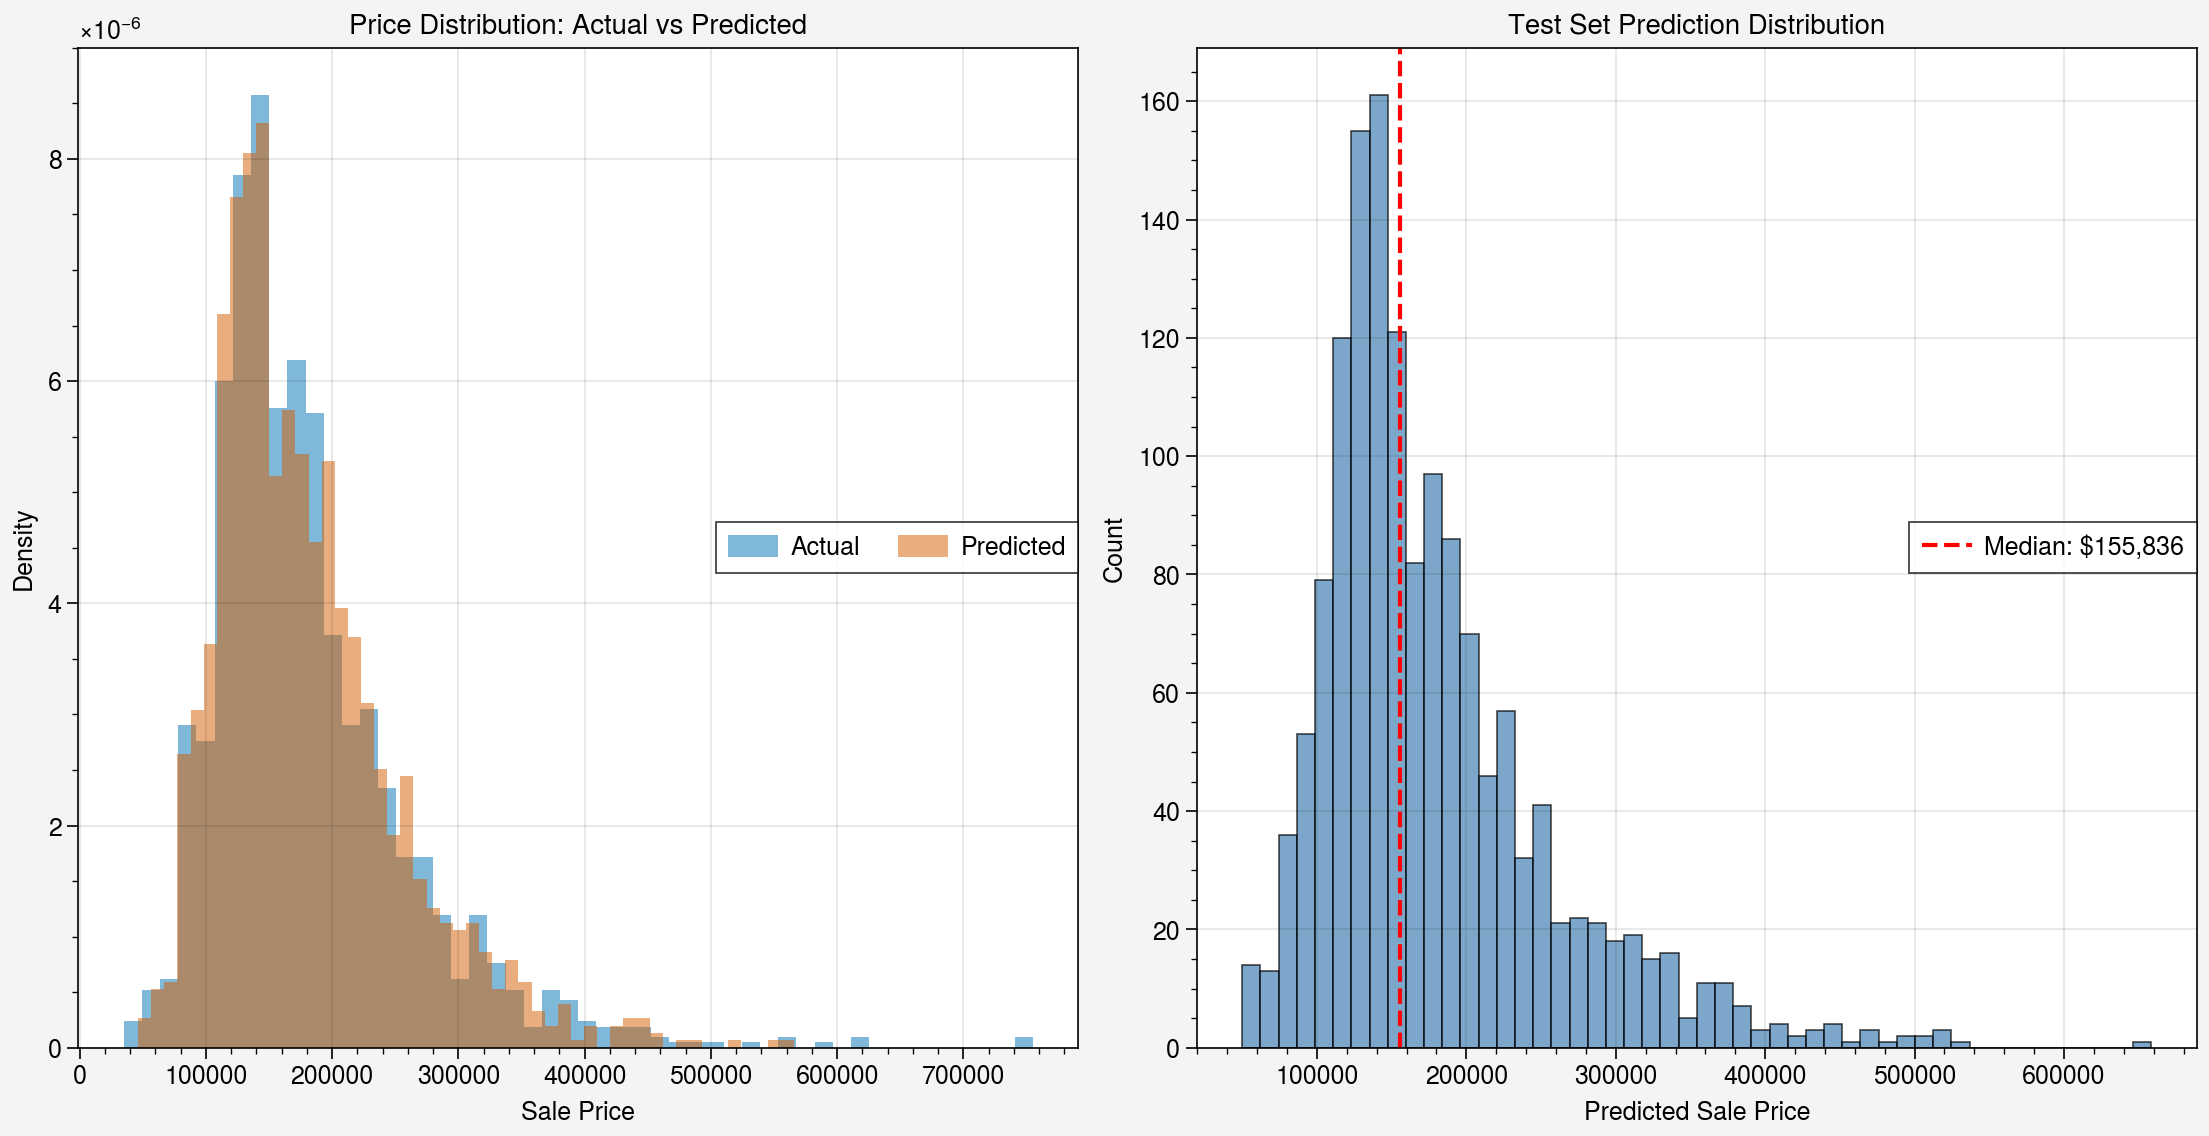

In [ ]:
fig, axs=uplt.subplots(nrows=1, ncols=2, refwidth=5, share=False)
ax1=axs[0]
ax1.hist(np.expm1(ylog), bins=50, alpha=0.5, label='Actual', density=True)
ax1.hist(np.expm1(ensemble_pred), bins=50, alpha=0.5, label='Predicted', density=True)
ax1.format(xlabel='Sale Price', ylabel='Density', title='Price Distribution: Actual vs Predicted')
ax1.legend()
ax2=axs[1]
ax2.hist(fpreds, bins=50, edgecolor='k', alpha=0.7, color='steelblue')
ax2.axvline(np.median(fpreds), color='red', linestyle='--', label=f'Median: ${np.median(fpreds):,.0f}')
ax2.format(xlabel='Predicted Sale Price', ylabel='Count', title='Test Set Prediction Distribution')
ax2.legend()

In [ ]:
# traindata_summary, train_model_suggestion=ddb.analyze_dataset('train.csv')
# print(traindata_summary)
# print(train_model_suggestion)
# testdata_summary, test_model_suggestion=ddb.analyze_dataset('test.csv')
# print(testdata_summary)
# print(test_model_suggestion)

In [ ]:
#!jupyter nbconvert --to script WMQhouseprice.ipynb
!jupytext --set-formats ipynb,py WMQhouseprice.ipynb